In [1]:
# OutfitTransformer TFG

# Requirements needed: (python3.12)
# - pip:
#    - torch==2.5.0
#    - torchvision==0.20.0
#    - torchaudio==2.5.0
#    - pillow==11.0.0
#    - transformers==4.48.3
#    - scikit-learn
#    - faiss-cpu
#    - wandb
#    - tqdm
#    - gradio
#    - opencv-python
#

# To dowload the data:
    # mkdir -p datasets
    # gdown --id 1ox8GFHG8iMs64iiwITQhJ47dkQ0Q7SBu -O polyvore.zip
    # unzip polyvore.zip -d ./datasets/polyvore
    # rm polyvore.zip

In [2]:

# ------------------------------
# Section 1: Setup and Imports
# ------------------------------

# Import standard libraries for data handling, logging, and visualization
import json
import logging
import os
import pathlib
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm import tqdm
from typing import Any, Dict, List, Literal, Optional
from dataclasses import dataclass
import os

# Import PyTorch and related modules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F

# Import torchvision for image preprocessing
import torchvision.transforms as transforms

# Import transformers for CLIP model
from transformers import CLIPProcessor, CLIPModel

# Import sklearn for metrics
from sklearn.metrics import roc_auc_score


/home/ia/Documentos/TFG_Lara/TransformingFashion/outfit_transformer_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Disable tokenizer parallelism to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define project-wide paths
SRC_DIR = pathlib.Path(os.getcwd()).absolute()
LOGS_DIR = SRC_DIR / 'logs'
CHECKPOINT_DIR = SRC_DIR / 'checkpoints'
POLYVORE_DIR = './datasets/polyvore'
POLYVORE_METADATA_PATH = f"{POLYVORE_DIR}/item_metadata.json"
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"
POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR = f"{POLYVORE_DIR}/precomputed_clip_embeddings"
POLYVORE_TASK_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_task}}/{{dataset_split}}.json"
POLYVORE_SET_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_split}}.json"

# Create directories if they don't exist
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'compatibility_clip', exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'complementary_clip', exist_ok=True)
os.makedirs(POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR, exist_ok=True)

# Configure logging for the entire notebook
logging.basicConfig(
    filename=LOGS_DIR / 'outfit_transformer.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('outfit_transformer')

# Log notebook start
logger.info("Starting OutfitTransformer notebook")
print("Starting OutfitTransformer notebook")


Starting OutfitTransformer notebook


In [4]:

# ------------------------------
# Section 2: Utility Functions and Classes
# ------------------------------

# Utility function to set random seeds for reproducibility
def seed_everything(seed=42):
    """Set random seeds for reproducibility across random, numpy, and PyTorch.
    
    Args:
        seed (int): Random seed value (default: 42).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    logger.info(f"Set random seed to {seed}")

# Set seed for reproducibility
seed_everything(42)

# FashionItem class to represent items in the Polyvore dataset
class FashionItem:
    """Represents a fashion item with metadata, image, and embedding.
    
    Attributes:
        item_id (str): Unique identifier for the item.
        category (str): Semantic category (e.g., top, bottom, shoes).
        image (PIL.Image or None): Loaded image of the item.
        description (str): Text description or title of the item.
        metadata (dict): Additional metadata from item_metadata.json.
        embedding (np.ndarray or None): Precomputed CLIP embedding (1024,).
    """
    def __init__(self, item_id, category, image=None, description="", metadata=None, embedding=None):
        self.item_id = item_id
        self.category = category
        self.image = image
        self.description = description
        self.metadata = metadata or {}
        self.embedding = embedding

# Load metadata from item_metadata.json
def load_metadata(dataset_dir):
    """Load item metadata from item_metadata.json.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
    
    Returns:
        dict: Dictionary mapping item_id to metadata.
    """
    metadata = {}
    with open(POLYVORE_METADATA_PATH.format(dataset_dir=dataset_dir), 'r') as f:
        metadata_ = json.load(f)
        for item in metadata_:
            metadata[item['item_id']] = item
    logger.info(f"Loaded {len(metadata)} metadata entries")
    print(f"Loaded {len(metadata)} metadata entries")
    return metadata

# Load image for an item
def load_image(dataset_dir, item_id, size=(224, 224)):
    """Load an image for a given item_id.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        item_id (str): Unique identifier for the item.
        size (tuple): Target image size (height, width) (default: (224, 224)).
    
    Returns:
        PIL.Image or None: Loaded image or None if loading fails.
    """
    image_path = POLYVORE_IMAGE_DATA_PATH.format(dataset_dir=dataset_dir, item_id=item_id)
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        logger.error(f"Error loading image {image_path}: {e}")
        print(f"Error loading image {image_path}: {e}")
        return None

# Load a FashionItem object
def load_item(dataset_dir, metadata, item_id, should_load_image=False, embedding_dict=None):
    """Load a FashionItem object with metadata, image, and embedding.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Dictionary of item metadata.
        item_id (str): Unique identifier for the item.
        should_load_image (bool): Whether to load the item image.
        embedding_dict (dict or None): Dictionary mapping item_id to CLIP embedding.
    
    Returns:
        FashionItem: Object containing item data.
    """
    metadata_ = metadata[item_id]
    return FashionItem(
        item_id=metadata_['item_id'],
        category=metadata_['semantic_category'],
        image=load_image(dataset_dir, metadata_['item_id']) if should_load_image else None,
        description=metadata_['title'] if metadata_.get('title') else metadata_['url_name'],
        metadata=metadata_,
        embedding=embedding_dict[item_id] if embedding_dict else None
    )

# Load precomputed CLIP embeddings
def load_embedding_dict(dataset_dir):
    """Load precomputed CLIP embeddings from .pkl files.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
    
    Returns:
        dict: Dictionary mapping item_id to embedding (1024,).
    """
    e_dir = POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR.format(polyvore_dir=dataset_dir)
    filenames = [f for f in os.listdir(e_dir) if f.endswith('.pkl') and 'official' not in f]
    filenames.sort(key=lambda x: int(x.split('.')[0].split('_')[-1]))
    
    all_ids, all_embeddings = [], []
    for filename in filenames:
        filepath = os.path.join(e_dir, filename)
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            all_ids += data['ids']
            all_embeddings.append(data['embeddings'])
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items, 1024)
    embedding_dict = {item_id: embedding for item_id, embedding in zip(all_ids, all_embeddings)}
    logger.info(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    print(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    return embedding_dict

# Load task data from JSON files
def load_task_data(dataset_dir, dataset_type, task, dataset_split):
    """Load task-specific data from JSON files.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        task (str): Task name (e.g., 'compatibility', 'fill_in_the_blank').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').
    
    Returns:
        list: List of task data entries.
    """
    with open(
        POLYVORE_TASK_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_task=task,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {task} {dataset_split} entries")
    return data

# Load set data for CIR training
def load_set_data(dataset_dir, dataset_type, dataset_split):
    """Load set data for CIR training from JSON files.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').
    
    Returns:
        list: List of set data entries.
    """
    with open(
        POLYVORE_SET_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {dataset_split} set entries")
    return data


def load_checkpoint(model, checkpoint_path):
    """Load a model's state dictionary from a checkpoint file.

    Args:
        model (nn.Module): The model to load the state dictionary into.
        checkpoint_path (str): Path to the checkpoint file (.pth).

    Returns:
        nn.Module: The model with the loaded state dictionary, set to evaluation mode.

    Notes:
        - The checkpoint file is expected to contain a dictionary with a 'model' key
          mapping to the state dictionary.
        - The function uses map_location to ensure compatibility with CPU/GPU environments.
    """
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    logger.info(f"Loaded checkpoint from {checkpoint_path}")
    return model


In [5]:

# ------------------------------
# Section 3: Generate CLIP Embeddings
# ------------------------------

# Dataset for generating CLIP embeddings
class PolyvoreItemDataset(Dataset):
    """Dataset for loading Polyvore items to generate CLIP embeddings.
    
    Attributes:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Item metadata.
        load_image (bool): Whether to load images.
        all_item_ids (list): List of all item IDs.
    """
    def __init__(self, dataset_dir, metadata=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.load_image = load_image
        self.all_item_ids = list(self.metadata.keys())
        logger.info(f"Initialized PolyvoreItemDataset with {len(self.all_item_ids)} items")

    def __len__(self):
        return len(self.all_item_ids)

    def __getitem__(self, idx):
        return load_item(self.dataset_dir, self.metadata, self.all_item_ids[idx], 
                         should_load_image=self.load_image)

# Collate function for item dataset
def item_collate_fn(batch):
    """Collate function for PolyvoreItemDataset.
    
    Args:
        batch (list): List of FashionItem objects.
    
    Returns:
        list: List of FashionItem objects.
    """
    return [item for item in batch]

# Distributed setup for DDP
def setup(rank, world_size):
    """Initialize DDP process group.
    
    Args:
        rank (int): Rank of the current process.
        world_size (int): Total number of processes (GPUs).
    """
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    logger.info(f"DDP initialized for rank {rank}")

def cleanup():
    """Destroy DDP process group."""
    dist.destroy_process_group()
    logger.info("DDP process group destroyed")

# Load CLIP model
def load_clip_model(checkpoint=None):
    """Load the Fashion-CLIP model.
    
    Args:
        checkpoint (str or None): Path to a checkpoint (not used in this case).
    
    Returns:
        tuple: (CLIPModel, CLIPProcessor).
    """
    model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
    processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")
    model.eval()
    logger.info("Loaded Fashion-CLIP model and processor")
    return model, processor

# Compute CLIP embeddings
def precompute_clip_embedding(model, processor, batch):
    """Compute CLIP embeddings for a batch of items.
    
    Args:
        model (CLIPModel): Fashion-CLIP model.
        processor (CLIPProcessor): CLIP processor.
        batch (list): List of FashionItem objects.
    
    Returns:
        np.ndarray: Concatenated image and text embeddings (batch_size, 1024).
    """
    images = [item.image for item in batch]
    texts = [item.description for item in batch]
    
    # Process images and texts
    # Input: images (list of PIL.Image), texts (list of str)
    # Output: inputs (dict with 'pixel_values' (batch_size, 3, 224, 224), 'input_ids', etc.)
    inputs = processor(images=images, text=texts, return_tensors="pt", padding=True, 
                      truncation=True, max_length=64)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Generate embeddings
    # Input: pixel_values (batch_size, 3, 224, 224), input_ids (batch_size, seq_len)
    # Output: image_embeds (batch_size, 512), text_embeds (batch_size, 512)
    with torch.no_grad():
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds  # (batch_size, 512)
        text_embeds = outputs.text_embeds    # (batch_size, 512)
        embeddings = torch.cat((image_embeds, text_embeds), dim=-1)  # (batch_size, 1024)
    
    return embeddings.cpu().numpy()  # (batch_size, 1024)

# Main function to compute embeddings
def compute_clip_embeddings(rank, world_size, args):
    """Compute and save CLIP embeddings for Polyvore items using DDP.
    
    Args:
        rank (int): Rank of the current process.
        world_size (int): Total number of processes (GPUs).
        args (Args): Configuration arguments.
    """
    # Initialize DDP
    if world_size > 1:
        setup(rank, world_size)
    
    # Load dataset
    item_dataset = PolyvoreItemDataset(
        dataset_dir=args.polyvore_dir,
        load_image=True
    )
    
    # Split dataset across GPUs
    n_items = len(item_dataset)
    n_items_per_gpu = n_items // world_size
    start_idx = n_items_per_gpu * rank
    end_idx = start_idx + n_items_per_gpu if rank < world_size - 1 else n_items
    item_dataset = torch.utils.data.Subset(item_dataset, range(start_idx, end_idx))
    logger.info(f"Rank {rank}: Processing items {start_idx} to {end_idx}")
    
    # Create DataLoader
    item_dataloader = DataLoader(
        dataset=item_dataset,
        batch_size=args.batch_sz_per_gpu,
        shuffle=False,
        num_workers=args.n_workers_per_gpu,
        collate_fn=item_collate_fn
    )
    
    # Load CLIP model
    model, processor = load_clip_model()
    model.to(rank)
    if world_size > 1:
        model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])
    
    # Compute embeddings
    all_ids, all_embeddings = [], []
    with torch.no_grad():
        for batch in tqdm(item_dataloader, desc=f"Rank {rank} Computing Embeddings"):
            if args.demo and len(all_embeddings) > 10:
                break
            embeddings = precompute_clip_embedding(model.module if world_size > 1 else model, 
                                                  processor, batch)  # (batch_size, 1024)
            all_ids.extend([item.item_id for item in batch])
            all_embeddings.append(embeddings)
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items_per_gpu, 1024)
    logger.info(f"Rank {rank}: Computed {len(all_embeddings)} embeddings")
    print(f"Rank {rank}: Computed {len(all_embeddings)} embeddings")
    
    # Save embeddings
    save_path = f"{POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR}/polyvore_{rank}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump({'ids': all_ids, 'embeddings': all_embeddings}, f)
    logger.info(f"Rank {rank}: Saved embeddings to {save_path}")
    print(f"Rank {rank}: Saved embeddings to {save_path}")
    
    # Cleanup DDP
    if world_size > 1:
        cleanup()

# Configuration for embedding generation
class EmbeddingArgs:
    """Configuration for generating CLIP embeddings."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 128
    n_workers_per_gpu = 4
    checkpoint = None
    world_size = torch.cuda.device_count() if torch.cuda.is_available() else 1
    demo = False

embedding_args = EmbeddingArgs()
logger.info(f"Embedding Arguments: {vars(embedding_args)}")
print(f"Embedding Arguments: {vars(embedding_args)}")


Embedding Arguments: {}


In [6]:

# Run embedding computation
# check if the embedding file already exists
embedding_files = [f for f in os.listdir(POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR) if f.endswith('.pkl')]
if embedding_files:
    logger.info("Precomputed CLIP embeddings already exist. Skipping computation.")
    print("Precomputed CLIP embeddings already exist. Skipping computation.")
else:
    logger.info("Starting computation of CLIP embeddings")
    print("Starting computation of CLIP embeddings")
    if embedding_args.world_size > 1:

        logger.info("Starting distributed computation of CLIP embeddings")
        print("Starting distributed computation of CLIP embeddings") 
        mp.spawn(
            compute_clip_embeddings,
            args=(embedding_args.world_size, embedding_args),
            nprocs=embedding_args.world_size,
            join=True
        )
    else:
        compute_clip_embeddings(0, 1, embedding_args)


Precomputed CLIP embeddings already exist. Skipping computation.


In [7]:

# ------------------------------
# Section 4: Train Compatibility Prediction (CP)
# ------------------------------

# Dataset for CP training
class PolyvoreCompatibilityDataset(Dataset):
    """Dataset for Compatibility Prediction task.
    
    Attributes:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Item metadata.
        data (list): List of outfit data with labels.
        load_image (bool): Whether to load images.
        embedding_dict (dict): Dictionary mapping item_id to CLIP embedding.
    
    Data Format:
        Each item in data is a dict with:
            'question': List of item IDs for the outfit.
            'label': Binary label (0: incompatible, 1: compatible).
    """
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='train', 
                 metadata=None, load_image=False, embedding_dict=None):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_task_data(dataset_dir, dataset_type, 'compatibility', dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        # Validate label distribution
        labels = [item['label'] for item in self.data]
        label_counts = Counter(labels)
        logger.info(f"{dataset_split} CP dataset: {len(self.data)} outfits, Label distribution: {label_counts}")
        print(f"{dataset_split} CP dataset: {len(self.data)} outfits, Label distribution: {label_counts}")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Return outfit and label
        label = self.data[idx]['label']
        outfit = [
            load_item(self.dataset_dir, self.metadata, item_id, self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['question']
        ]
        return {'label': label, 'query': outfit}

# Collate function for CP
def cp_collate_fn(batch):
    """Collate function for PolyvoreCompatibilityDataset.
    
    Args:
        batch (list): List of dicts with 'label' and 'query'.
    
    Returns:
        dict: Dictionary with 'label' (list of int) and 'query' (list of lists of FashionItem).
    """
    labels = [item['label'] for item in batch]
    queries = [item['query'] for item in batch]
    return {'label': labels, 'query': queries}

# Focal Loss for CP
class FocalLoss(nn.Module):
    """Focal Loss for binary classification, emphasizing hard examples.
    
    Args:
        gamma (float): Focusing parameter (default: 2).
        alpha (float): Weight for positive class (default: 0.5).
        reduction (str): Reduction method ('mean', 'sum', or 'none').
    
    Forward:
        Input:
            y_prob (torch.Tensor): Predicted logits (batch_size,).
            y_true (torch.Tensor): True labels (batch_size,).
        Output:
            torch.Tensor: Scalar loss (if reduction='mean').
    """
    def __init__(self, gamma=2, alpha=0.5, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, y_prob, y_true):
        ce_loss = F.binary_cross_entropy_with_logits(y_prob, y_true, reduction="none")
        p_t = y_prob * y_true + (1 - y_prob) * (1 - y_true)
        loss = ce_loss * ((1 - p_t) ** self.gamma)
        if self.alpha >= 0:
            alpha_t = self.alpha * y_true + (1 - self.alpha) * (1 - y_true)
            loss = alpha_t * loss
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Metrics for CP
def compute_cp_scores(predictions, labels):
    """Compute metrics for Compatibility Prediction.
    
    Args:
        predictions (torch.Tensor): Predicted logits (batch_size,).
        labels (torch.Tensor): True labels (batch_size,).
    
    Returns:
        dict: Metrics including 'acc', 'precision', 'recall', 'f1', 'auc'.
    """
    try:
        auc = roc_auc_score(labels.detach().cpu().numpy(), 
                           predictions.detach().cpu().numpy()) if len(torch.unique(labels)) > 1 else 0.0
    except ValueError as e:
        logger.warning(f"AUC calculation failed: {e}. Setting auc=0.0")
        auc = 0.0
    predictions = (predictions > 0).int()  # Threshold at 0 for logits
    tp = torch.sum((predictions == 1) & (labels == 1)).item()
    fp = torch.sum((predictions == 1) & (labels == 0)).item()
    fn = torch.sum((predictions == 0) & (labels == 1)).item()
    accuracy = torch.mean((predictions == labels).float()).item()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return {'acc': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

# Configuration for OutfitTransformer
@dataclass
class OutfitTransformerConfig:
    """Configuration for OutfitTransformer model."""
    n_items: int = 251008  # Number of unique items in Polyvore
    d_model: int = 128     # Embedding dimension
    n_layers: int = 4      # Number of transformer layers
    n_head: int = 4        # Number of attention heads
    dropout: float = 0.1   # Dropout rate
    item_enc_norm_out: bool = True
    aggregation_method: str = 'concat'

@dataclass
class OutfitCLIPTransformerConfig(OutfitTransformerConfig):
    """Configuration for OutfitCLIPTransformer, extending OutfitTransformerConfig."""
    item_enc_clip_model_name: str = "patrickjohncyh/fashion-clip"

# OutfitTransformer model
class OutfitTransformer(nn.Module):
    """Transformer model for outfit compatibility prediction.
    
    Architecture:
        - Input: List of outfits, each a list of FashionItem objects with CLIP embeddings (1024,).
        - Linear layer: Projects CLIP embeddings to d_model (1024 -> 128).
        - CLS token: Learnable token prepended to each outfit sequence.
        - Transformer Encoder: Processes outfit embeddings with attention.
        - Classification Head: Maps CLS token embedding to a logit.
    
    Args:
        cfg (OutfitTransformerConfig): Model configuration.
    
    Forward:
        Input:
            queries (List[List[FashionItem]]): Batch of outfits, each a list of items.
            use_precomputed_embedding (bool): Whether to use precomputed CLIP embeddings.
        Output:
            torch.Tensor: Logits (batch_size,) for compatibility prediction.
    """
    def __init__(self, cfg=OutfitTransformerConfig()):
        super().__init__()
        self.cfg = cfg
        # Linear layer to project CLIP embeddings (1024,) to model dimension (128,)
        self.fc = nn.Linear(1024, cfg.d_model)
        # Transformer encoder layer with multi-head attention
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model, nhead=cfg.n_head, dropout=cfg.dropout, batch_first=True
        )
        # Stack of transformer encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=cfg.n_layers)
        # Learnable CLS token for outfit representation
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model))
        # Classification head to predict compatibility
        self.classification_head = nn.Linear(cfg.d_model, 1)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, queries, use_precomputed_embedding=True):
        # queries: List of outfits, each a list of FashionItem objects
        batch_size = len(queries)  # Number of outfits in the batch
        max_len = max(len(query) for query in queries)  # Maximum number of items in any outfit
        
        # Prepare embeddings and mask
        embeddings = []
        mask = []
        for query in queries:
            # Extract precomputed CLIP embeddings for each item
            # Shape: (seq_len, 1024), where seq_len is number of items in outfit
            outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
                dtype=torch.float32, device=self.device
            )
            # Pad embeddings to max_len
            padded_embeds = torch.zeros(max_len, 1024, device=self.device)
            padded_embeds[:len(query)] = outfit_embeds
            embeddings.append(padded_embeds)
            # Create mask: 0 for valid items, 1 for padding
            outfit_mask = torch.zeros(max_len, device=self.device)
            outfit_mask[len(query):] = 1
            mask.append(outfit_mask)
        
        # Stack embeddings and mask
        embeddings = torch.stack(embeddings, dim=0)  # (batch_size, max_len, 1024)
        mask = torch.stack(mask, dim=0)  # (batch_size, max_len)
        
        # Project embeddings to model dimension
        embeddings = self.fc(embeddings)  # (batch_size, max_len, d_model)
        
        # Add CLS token
        cls_token = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, d_model)
        features = torch.cat([cls_token, embeddings], dim=1)  # (batch_size, max_len+1, d_model)
        
        # Update mask for CLS token
        cls_mask = torch.zeros(batch_size, 1, device=self.device)  # CLS token is valid (0)
        mask = torch.cat([cls_mask, mask], dim=1)  # (batch_size, max_len+1)
        
        # Apply transformer encoder
        # Input: features (batch_size, max_len+1, d_model), mask (batch_size, max_len+1)
        # Output: transformed_features (batch_size, max_len+1, d_model)
        transformed_features = self.transformer_encoder(features, src_key_padding_mask=mask.bool())
        
        # Extract CLS token embedding
        outfit_embedding = transformed_features[:, 0, :]  # (batch_size, d_model)
        
        # Predict compatibility
        logits = self.classification_head(outfit_embedding)  # (batch_size, 1)
        return logits.squeeze(-1)  # (batch_size,)

# OutfitCLIPTransformer model
class OutfitCLIPTransformer(OutfitTransformer):
    """OutfitTransformer specialized for CLIP embeddings.
    
    Args:
        cfg (OutfitCLIPTransformerConfig): Model configuration.
    """
    def __init__(self, cfg=OutfitCLIPTransformerConfig()):
        super().__init__(cfg)
        logger.info("Initialized OutfitCLIPTransformer")

# Training function for CP
def train_cp(args, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_fn, device):
    """Train the Compatibility Prediction model.
    
    Args:
        args (Args): Training arguments.
        model (OutfitCLIPTransformer): Model to train.
        train_dataloader (DataLoader): Training DataLoader.
        valid_dataloader (DataLoader): Validation DataLoader.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        loss_fn (nn.Module): Loss function (FocalLoss).
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        tuple: Lists of train_losses, valid_losses, train_aucs, valid_aucs.
    """
    train_losses, valid_losses, train_aucs, valid_aucs = [], [], [], []
    
    for epoch in range(args.n_epochs):
        # Training
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []
        pbar = tqdm(train_dataloader, desc=f'Train CP Epoch {epoch+1}/{args.n_epochs}')
        for i, data in enumerate(pbar):
            queries = data['query']
            labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
            # Forward pass
            # Input: queries (batch_size lists of FashionItem)
            # Output: preds (batch_size,) logits
            preds = model(queries, use_precomputed_embedding=True)
            # Compute loss
            loss = loss_fn(preds, labels) / args.accumulation_steps
            loss.backward()
            # Gradient accumulation
            if (i + 1) % args.accumulation_steps == 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
            train_loss += loss.item() * args.accumulation_steps
            train_preds.append(preds.detach())
            train_labels.append(labels.detach())
            pbar.set_postfix(loss=loss.item() * args.accumulation_steps)
        
        train_loss /= len(train_dataloader)
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        train_scores = compute_cp_scores(train_preds, train_labels)
        train_losses.append(train_loss)
        train_aucs.append(train_scores['auc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Train CP --> Loss: {train_loss:.4f}, '
                   f'AUC: {train_scores["auc"]:.4f}, Acc: {train_scores["acc"]:.4f}, '
                   f'F1: {train_scores["f1"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Train CP --> Loss: {train_loss:.4f}, '
              f'AUC: {train_scores["auc"]:.4f}, Acc: {train_scores["acc"]:.4f}, '
              f'F1: {train_scores["f1"]:.4f}')
        
        # Validation
        model.eval()
        valid_loss, valid_preds, valid_labels = 0.0, [], []
        pbar = tqdm(valid_dataloader, desc=f'Valid CP Epoch {epoch+1}/{args.n_epochs}')
        with torch.no_grad():
            for data in pbar:
                queries = data['query']
                labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
                preds = model(queries, use_precomputed_embedding=True)
                loss = loss_fn(preds, labels)
                valid_loss += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
                pbar.set_postfix(loss=loss.item())
        
        valid_loss /= len(valid_dataloader)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)
        valid_scores = compute_cp_scores(valid_preds, valid_labels)
        valid_losses.append(valid_loss)
        valid_aucs.append(valid_scores['auc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Valid CP --> Loss: {valid_loss:.4f}, '
                   f'AUC: {valid_scores["auc"]:.4f}, Acc: {valid_scores["acc"]:.4f}, '
                   f'F1: {valid_scores["f1"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Valid CP --> Loss: {valid_loss:.4f}, '
              f'AUC: {valid_scores["auc"]:.4f}, Acc: {valid_scores["acc"]:.4f}, '
              f'F1: {valid_scores["f1"]:.4f}')
        
        # Save checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', f'epoch_{epoch+1}.pth')
        torch.save({'config': model.cfg.__dict__, 'model': model.state_dict()}, checkpoint_path)
        logger.info(f'Checkpoint saved at {checkpoint_path}')
        print(f'Checkpoint saved at {checkpoint_path}')
    
    return train_losses, valid_losses, train_aucs, valid_aucs

# Configuration for CP training
class CPArgs:
    """Configuration for Compatibility Prediction training."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    n_epochs = 200
    lr = 2e-5
    accumulation_steps = 4
    wandb_key = None
    seed = 42
    checkpoint = None
    world_size = 1
    project_name = 'compatibility_clip_notebook'
    demo = False


In [8]:

cp_args = CPArgs()
logger.info(f"CP Arguments: {vars(cp_args)}")
print(f"CP Arguments: {vars(cp_args)}")

# Load datasets for CP
metadata = load_metadata(cp_args.polyvore_dir)
embedding_dict = load_embedding_dict(cp_args.polyvore_dir)

train_dataset = PolyvoreCompatibilityDataset(
    dataset_dir=cp_args.polyvore_dir,
    dataset_type=cp_args.polyvore_type,
    dataset_split='train',
    metadata=metadata,
    load_image=False,
    embedding_dict=embedding_dict
)

valid_dataset = PolyvoreCompatibilityDataset(
    dataset_dir=cp_args.polyvore_dir,
    dataset_type=cp_args.polyvore_type,
    dataset_split='valid',
    metadata=metadata,
    load_image=False,
    embedding_dict=embedding_dict
)

# Create DataLoaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=cp_args.batch_sz_per_gpu,
    shuffle=True,
    num_workers=cp_args.n_workers_per_gpu,
    collate_fn=cp_collate_fn
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=cp_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cp_args.n_workers_per_gpu,
    collate_fn=cp_collate_fn
)

# Initialize model, optimizer, scheduler, and loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cp_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
cp_optimizer = optim.AdamW(cp_model.parameters(), lr=cp_args.lr)
cp_scheduler = optim.lr_scheduler.OneCycleLR(
    cp_optimizer,
    max_lr=cp_args.lr,
    epochs=cp_args.n_epochs,
    steps_per_epoch=int(len(train_dataloader) / cp_args.accumulation_steps),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
cp_loss_fn = FocalLoss(alpha=0.5, gamma=2)


CP Arguments: {}
Loaded 251008 metadata entries
Loaded 251008 embeddings into dictionary
train CP dataset: 106612 outfits, Label distribution: Counter({1: 53306, 0: 53306})
valid CP dataset: 10000 outfits, Label distribution: Counter({1: 5000, 0: 5000})


In [9]:

# Train CP model
train_losses, valid_losses, train_aucs, valid_aucs = train_cp(
    cp_args, cp_model, train_dataloader, valid_dataloader, 
    cp_optimizer, cp_scheduler, cp_loss_fn, device
)

Train CP Epoch 1/200: 100%|██████████| 3332/3332 [00:31<00:00, 106.12it/s, loss=0.0796]


Epoch 1/200 Train CP --> Loss: 0.1198, AUC: 0.5032, Acc: 0.5007, F1: 0.6490


Valid CP Epoch 1/200:   0%|          | 0/313 [00:00<?, ?it/s]/home/ia/Documentos/TFG_Lara/TransformingFashion/outfit_transformer_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Valid CP Epoch 1/200: 100%|██████████| 313/313 [00:01<00:00, 162.69it/s, loss=0.0591]


Epoch 1/200 Valid CP --> Loss: 0.0831, AUC: 0.5045, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_1.pth


Train CP Epoch 2/200: 100%|██████████| 3332/3332 [00:31<00:00, 107.39it/s, loss=0.0887]


Epoch 2/200 Train CP --> Loss: 0.0884, AUC: 0.4980, Acc: 0.5000, F1: 0.6666


Valid CP Epoch 2/200: 100%|██████████| 313/313 [00:01<00:00, 165.15it/s, loss=0.0622]


Epoch 2/200 Valid CP --> Loss: 0.0827, AUC: 0.5092, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_2.pth


Train CP Epoch 3/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.26it/s, loss=0.0946]


Epoch 3/200 Train CP --> Loss: 0.0867, AUC: 0.4998, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 3/200: 100%|██████████| 313/313 [00:01<00:00, 158.38it/s, loss=0.0626]


Epoch 3/200 Valid CP --> Loss: 0.0826, AUC: 0.5128, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_3.pth


Train CP Epoch 4/200: 100%|██████████| 3332/3332 [00:31<00:00, 104.36it/s, loss=0.0791]


Epoch 4/200 Train CP --> Loss: 0.0859, AUC: 0.5009, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 4/200: 100%|██████████| 313/313 [00:02<00:00, 147.78it/s, loss=0.0638]


Epoch 4/200 Valid CP --> Loss: 0.0826, AUC: 0.5162, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_4.pth


Train CP Epoch 5/200: 100%|██████████| 3332/3332 [00:31<00:00, 104.77it/s, loss=0.0738]


Epoch 5/200 Train CP --> Loss: 0.0852, AUC: 0.5030, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 5/200: 100%|██████████| 313/313 [00:01<00:00, 161.07it/s, loss=0.0629]


Epoch 5/200 Valid CP --> Loss: 0.0826, AUC: 0.5176, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_5.pth


Train CP Epoch 6/200: 100%|██████████| 3332/3332 [00:31<00:00, 106.92it/s, loss=0.0882]


Epoch 6/200 Train CP --> Loss: 0.0850, AUC: 0.4994, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 6/200: 100%|██████████| 313/313 [00:01<00:00, 164.93it/s, loss=0.0594]


Epoch 6/200 Valid CP --> Loss: 0.0828, AUC: 0.5208, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_6.pth


Train CP Epoch 7/200: 100%|██████████| 3332/3332 [00:31<00:00, 106.30it/s, loss=0.0817]


Epoch 7/200 Train CP --> Loss: 0.0845, AUC: 0.5029, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 7/200: 100%|██████████| 313/313 [00:01<00:00, 159.04it/s, loss=0.0642]


Epoch 7/200 Valid CP --> Loss: 0.0825, AUC: 0.5278, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_7.pth


Train CP Epoch 8/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.99it/s, loss=0.0852]


Epoch 8/200 Train CP --> Loss: 0.0842, AUC: 0.5020, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 8/200: 100%|██████████| 313/313 [00:01<00:00, 160.29it/s, loss=0.0599]


Epoch 8/200 Valid CP --> Loss: 0.0827, AUC: 0.5338, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_8.pth


Train CP Epoch 9/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.35it/s, loss=0.0769]


Epoch 9/200 Train CP --> Loss: 0.0839, AUC: 0.5061, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 9/200: 100%|██████████| 313/313 [00:01<00:00, 156.54it/s, loss=0.055] 


Epoch 9/200 Valid CP --> Loss: 0.0831, AUC: 0.5436, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_9.pth


Train CP Epoch 10/200: 100%|██████████| 3332/3332 [00:31<00:00, 104.30it/s, loss=0.0799]


Epoch 10/200 Train CP --> Loss: 0.0837, AUC: 0.5057, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 10/200: 100%|██████████| 313/313 [00:01<00:00, 161.06it/s, loss=0.0594]


Epoch 10/200 Valid CP --> Loss: 0.0826, AUC: 0.5617, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_10.pth


Train CP Epoch 11/200: 100%|██████████| 3332/3332 [00:31<00:00, 107.06it/s, loss=0.0862]


Epoch 11/200 Train CP --> Loss: 0.0836, AUC: 0.5033, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 11/200: 100%|██████████| 313/313 [00:01<00:00, 163.99it/s, loss=0.0626]


Epoch 11/200 Valid CP --> Loss: 0.0822, AUC: 0.5965, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_11.pth


Train CP Epoch 12/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.34it/s, loss=0.0868]


Epoch 12/200 Train CP --> Loss: 0.0829, AUC: 0.5246, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 12/200: 100%|██████████| 313/313 [00:01<00:00, 170.16it/s, loss=0.0546]


Epoch 12/200 Valid CP --> Loss: 0.0804, AUC: 0.6571, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_12.pth


Train CP Epoch 13/200: 100%|██████████| 3332/3332 [00:27<00:00, 121.73it/s, loss=0.0741]


Epoch 13/200 Train CP --> Loss: 0.0787, AUC: 0.6277, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 13/200: 100%|██████████| 313/313 [00:01<00:00, 167.63it/s, loss=0.0544]


Epoch 13/200 Valid CP --> Loss: 0.0751, AUC: 0.6872, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_13.pth


Train CP Epoch 14/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.99it/s, loss=0.0537]


Epoch 14/200 Train CP --> Loss: 0.0751, AUC: 0.6812, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 14/200: 100%|██████████| 313/313 [00:01<00:00, 194.47it/s, loss=0.0506]


Epoch 14/200 Valid CP --> Loss: 0.0705, AUC: 0.7366, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_14.pth


Train CP Epoch 15/200: 100%|██████████| 3332/3332 [00:28<00:00, 118.03it/s, loss=0.0594]


Epoch 15/200 Train CP --> Loss: 0.0707, AUC: 0.7310, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 15/200: 100%|██████████| 313/313 [00:01<00:00, 158.17it/s, loss=0.0517]


Epoch 15/200 Valid CP --> Loss: 0.0661, AUC: 0.7744, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_15.pth


Train CP Epoch 16/200: 100%|██████████| 3332/3332 [00:27<00:00, 123.28it/s, loss=0.0649]


Epoch 16/200 Train CP --> Loss: 0.0670, AUC: 0.7660, Acc: 0.5004, F1: 0.6668


Valid CP Epoch 16/200: 100%|██████████| 313/313 [00:01<00:00, 173.17it/s, loss=0.0533]


Epoch 16/200 Valid CP --> Loss: 0.0617, AUC: 0.8095, Acc: 0.5026, F1: 0.6678
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_16.pth


Train CP Epoch 17/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.10it/s, loss=0.0755]


Epoch 17/200 Train CP --> Loss: 0.0631, AUC: 0.7989, Acc: 0.5053, F1: 0.6689


Valid CP Epoch 17/200: 100%|██████████| 313/313 [00:01<00:00, 184.40it/s, loss=0.0561]


Epoch 17/200 Valid CP --> Loss: 0.0578, AUC: 0.8367, Acc: 0.5285, F1: 0.6791
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_17.pth


Train CP Epoch 18/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.83it/s, loss=0.0549]


Epoch 18/200 Train CP --> Loss: 0.0592, AUC: 0.8260, Acc: 0.5172, F1: 0.6741


Valid CP Epoch 18/200: 100%|██████████| 313/313 [00:02<00:00, 150.79it/s, loss=0.0586]


Epoch 18/200 Valid CP --> Loss: 0.0554, AUC: 0.8531, Acc: 0.5575, F1: 0.6921
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_18.pth


Train CP Epoch 19/200: 100%|██████████| 3332/3332 [00:27<00:00, 120.63it/s, loss=0.0511]


Epoch 19/200 Train CP --> Loss: 0.0566, AUC: 0.8434, Acc: 0.5291, F1: 0.6793


Valid CP Epoch 19/200: 100%|██████████| 313/313 [00:01<00:00, 181.76it/s, loss=0.0532]


Epoch 19/200 Valid CP --> Loss: 0.0535, AUC: 0.8673, Acc: 0.5885, F1: 0.7066
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_19.pth


Train CP Epoch 20/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.59it/s, loss=0.0783]


Epoch 20/200 Train CP --> Loss: 0.0544, AUC: 0.8565, Acc: 0.5369, F1: 0.6828


Valid CP Epoch 20/200: 100%|██████████| 313/313 [00:01<00:00, 193.06it/s, loss=0.0548]


Epoch 20/200 Valid CP --> Loss: 0.0511, AUC: 0.8766, Acc: 0.5750, F1: 0.7006
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_20.pth


Train CP Epoch 21/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.59it/s, loss=0.0708]


Epoch 21/200 Train CP --> Loss: 0.0526, AUC: 0.8667, Acc: 0.5414, F1: 0.6849


Valid CP Epoch 21/200: 100%|██████████| 313/313 [00:01<00:00, 165.87it/s, loss=0.0613]


Epoch 21/200 Valid CP --> Loss: 0.0496, AUC: 0.8833, Acc: 0.5680, F1: 0.6976
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_21.pth


Train CP Epoch 22/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.23it/s, loss=0.0836]


Epoch 22/200 Train CP --> Loss: 0.0507, AUC: 0.8765, Acc: 0.5462, F1: 0.6873


Valid CP Epoch 22/200: 100%|██████████| 313/313 [00:01<00:00, 180.24it/s, loss=0.0569]


Epoch 22/200 Valid CP --> Loss: 0.0495, AUC: 0.8884, Acc: 0.6106, F1: 0.7175
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_22.pth


Train CP Epoch 23/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.93it/s, loss=0.0501]


Epoch 23/200 Train CP --> Loss: 0.0490, AUC: 0.8851, Acc: 0.5515, F1: 0.6897


Valid CP Epoch 23/200: 100%|██████████| 313/313 [00:01<00:00, 170.66it/s, loss=0.0586]


Epoch 23/200 Valid CP --> Loss: 0.0473, AUC: 0.8958, Acc: 0.5883, F1: 0.7070
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_23.pth


Train CP Epoch 24/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.03it/s, loss=0.0244]


Epoch 24/200 Train CP --> Loss: 0.0474, AUC: 0.8931, Acc: 0.5573, F1: 0.6925


Valid CP Epoch 24/200: 100%|██████████| 313/313 [00:01<00:00, 171.34it/s, loss=0.0691]


Epoch 24/200 Valid CP --> Loss: 0.0461, AUC: 0.9024, Acc: 0.5831, F1: 0.7051
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_24.pth


Train CP Epoch 25/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.87it/s, loss=0.0568]


Epoch 25/200 Train CP --> Loss: 0.0460, AUC: 0.8999, Acc: 0.5620, F1: 0.6948


Valid CP Epoch 25/200: 100%|██████████| 313/313 [00:01<00:00, 175.53it/s, loss=0.0599]


Epoch 25/200 Valid CP --> Loss: 0.0447, AUC: 0.9085, Acc: 0.5828, F1: 0.7049
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_25.pth


Train CP Epoch 26/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.36it/s, loss=0.0269]


Epoch 26/200 Train CP --> Loss: 0.0446, AUC: 0.9063, Acc: 0.5668, F1: 0.6971


Valid CP Epoch 26/200: 100%|██████████| 313/313 [00:01<00:00, 167.39it/s, loss=0.0508]


Epoch 26/200 Valid CP --> Loss: 0.0431, AUC: 0.9139, Acc: 0.6085, F1: 0.7176
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_26.pth


Train CP Epoch 27/200: 100%|██████████| 3332/3332 [00:28<00:00, 118.27it/s, loss=0.0437]


Epoch 27/200 Train CP --> Loss: 0.0433, AUC: 0.9121, Acc: 0.5726, F1: 0.7000


Valid CP Epoch 27/200: 100%|██████████| 313/313 [00:01<00:00, 170.61it/s, loss=0.0561]


Epoch 27/200 Valid CP --> Loss: 0.0422, AUC: 0.9177, Acc: 0.6056, F1: 0.7163
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_27.pth


Train CP Epoch 28/200: 100%|██████████| 3332/3332 [00:29<00:00, 111.96it/s, loss=0.0191]


Epoch 28/200 Train CP --> Loss: 0.0422, AUC: 0.9173, Acc: 0.5765, F1: 0.7021


Valid CP Epoch 28/200: 100%|██████████| 313/313 [00:02<00:00, 154.51it/s, loss=0.044] 


Epoch 28/200 Valid CP --> Loss: 0.0413, AUC: 0.9216, Acc: 0.6284, F1: 0.7278
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_28.pth


Train CP Epoch 29/200: 100%|██████████| 3332/3332 [00:32<00:00, 103.57it/s, loss=0.0392]


Epoch 29/200 Train CP --> Loss: 0.0410, AUC: 0.9219, Acc: 0.5815, F1: 0.7045


Valid CP Epoch 29/200: 100%|██████████| 313/313 [00:01<00:00, 166.34it/s, loss=0.0338] 


Epoch 29/200 Valid CP --> Loss: 0.0413, AUC: 0.9246, Acc: 0.6483, F1: 0.7386
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_29.pth


Train CP Epoch 30/200: 100%|██████████| 3332/3332 [00:32<00:00, 103.86it/s, loss=0.0377]


Epoch 30/200 Train CP --> Loss: 0.0402, AUC: 0.9251, Acc: 0.5832, F1: 0.7053


Valid CP Epoch 30/200: 100%|██████████| 313/313 [00:01<00:00, 158.03it/s, loss=0.0354] 


Epoch 30/200 Valid CP --> Loss: 0.0403, AUC: 0.9275, Acc: 0.6454, F1: 0.7368
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_30.pth


Train CP Epoch 31/200: 100%|██████████| 3332/3332 [00:32<00:00, 101.14it/s, loss=0.0553]


Epoch 31/200 Train CP --> Loss: 0.0392, AUC: 0.9291, Acc: 0.5885, F1: 0.7079


Valid CP Epoch 31/200: 100%|██████████| 313/313 [00:01<00:00, 156.88it/s, loss=0.0394] 


Epoch 31/200 Valid CP --> Loss: 0.0393, AUC: 0.9294, Acc: 0.6313, F1: 0.7298
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_31.pth


Train CP Epoch 32/200: 100%|██████████| 3332/3332 [00:33<00:00, 100.42it/s, loss=0.0448]


Epoch 32/200 Train CP --> Loss: 0.0384, AUC: 0.9321, Acc: 0.5907, F1: 0.7091


Valid CP Epoch 32/200: 100%|██████████| 313/313 [00:02<00:00, 156.17it/s, loss=0.0362] 


Epoch 32/200 Valid CP --> Loss: 0.0383, AUC: 0.9331, Acc: 0.6384, F1: 0.7335
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_32.pth


Train CP Epoch 33/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.59it/s, loss=0.0192]


Epoch 33/200 Train CP --> Loss: 0.0371, AUC: 0.9364, Acc: 0.5963, F1: 0.7120


Valid CP Epoch 33/200: 100%|██████████| 313/313 [00:01<00:00, 168.43it/s, loss=0.0387]


Epoch 33/200 Valid CP --> Loss: 0.0378, AUC: 0.9355, Acc: 0.6191, F1: 0.7236
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_33.pth


Train CP Epoch 34/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.29it/s, loss=0.0299]


Epoch 34/200 Train CP --> Loss: 0.0363, AUC: 0.9392, Acc: 0.5989, F1: 0.7133


Valid CP Epoch 34/200: 100%|██████████| 313/313 [00:01<00:00, 158.47it/s, loss=0.0351] 


Epoch 34/200 Valid CP --> Loss: 0.0373, AUC: 0.9365, Acc: 0.6312, F1: 0.7297
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_34.pth


Train CP Epoch 35/200: 100%|██████████| 3332/3332 [00:32<00:00, 103.85it/s, loss=0.039] 


Epoch 35/200 Train CP --> Loss: 0.0355, AUC: 0.9422, Acc: 0.6016, F1: 0.7146


Valid CP Epoch 35/200: 100%|██████████| 313/313 [00:01<00:00, 169.12it/s, loss=0.0333]


Epoch 35/200 Valid CP --> Loss: 0.0371, AUC: 0.9381, Acc: 0.6424, F1: 0.7357
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_35.pth


Train CP Epoch 36/200: 100%|██████████| 3332/3332 [00:32<00:00, 103.65it/s, loss=0.0266]


Epoch 36/200 Train CP --> Loss: 0.0348, AUC: 0.9442, Acc: 0.6044, F1: 0.7161


Valid CP Epoch 36/200: 100%|██████████| 313/313 [00:01<00:00, 160.75it/s, loss=0.0289]


Epoch 36/200 Valid CP --> Loss: 0.0358, AUC: 0.9414, Acc: 0.6446, F1: 0.7369
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_36.pth


Train CP Epoch 37/200: 100%|██████████| 3332/3332 [00:32<00:00, 102.88it/s, loss=0.0309]


Epoch 37/200 Train CP --> Loss: 0.0339, AUC: 0.9469, Acc: 0.6071, F1: 0.7175


Valid CP Epoch 37/200: 100%|██████████| 313/313 [00:02<00:00, 154.76it/s, loss=0.0391]


Epoch 37/200 Valid CP --> Loss: 0.0370, AUC: 0.9381, Acc: 0.6275, F1: 0.7279
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_37.pth


Train CP Epoch 38/200: 100%|██████████| 3332/3332 [00:33<00:00, 100.38it/s, loss=0.0343] 


Epoch 38/200 Train CP --> Loss: 0.0332, AUC: 0.9488, Acc: 0.6082, F1: 0.7181


Valid CP Epoch 38/200: 100%|██████████| 313/313 [00:01<00:00, 164.53it/s, loss=0.0198] 


Epoch 38/200 Valid CP --> Loss: 0.0357, AUC: 0.9439, Acc: 0.6994, F1: 0.7675
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_38.pth


Train CP Epoch 39/200: 100%|██████████| 3332/3332 [00:32<00:00, 101.71it/s, loss=0.0566] 


Epoch 39/200 Train CP --> Loss: 0.0323, AUC: 0.9510, Acc: 0.6085, F1: 0.7183


Valid CP Epoch 39/200: 100%|██████████| 313/313 [00:01<00:00, 163.43it/s, loss=0.0307] 


Epoch 39/200 Valid CP --> Loss: 0.0354, AUC: 0.9439, Acc: 0.6535, F1: 0.7416
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_39.pth


Train CP Epoch 40/200: 100%|██████████| 3332/3332 [00:32<00:00, 102.67it/s, loss=0.0274] 


Epoch 40/200 Train CP --> Loss: 0.0316, AUC: 0.9527, Acc: 0.6100, F1: 0.7190


Valid CP Epoch 40/200: 100%|██████████| 313/313 [00:02<00:00, 154.22it/s, loss=0.0269] 


Epoch 40/200 Valid CP --> Loss: 0.0344, AUC: 0.9446, Acc: 0.6575, F1: 0.7440
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_40.pth


Train CP Epoch 41/200: 100%|██████████| 3332/3332 [00:31<00:00, 106.93it/s, loss=0.00982]


Epoch 41/200 Train CP --> Loss: 0.0307, AUC: 0.9549, Acc: 0.6092, F1: 0.7186


Valid CP Epoch 41/200: 100%|██████████| 313/313 [00:01<00:00, 180.44it/s, loss=0.0358] 


Epoch 41/200 Valid CP --> Loss: 0.0346, AUC: 0.9461, Acc: 0.6368, F1: 0.7329
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_41.pth


Train CP Epoch 42/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.41it/s, loss=0.0143] 


Epoch 42/200 Train CP --> Loss: 0.0301, AUC: 0.9562, Acc: 0.6076, F1: 0.7179


Valid CP Epoch 42/200: 100%|██████████| 313/313 [00:01<00:00, 175.58it/s, loss=0.0449]


Epoch 42/200 Valid CP --> Loss: 0.0359, AUC: 0.9467, Acc: 0.5896, F1: 0.7087
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_42.pth


Train CP Epoch 43/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.21it/s, loss=0.0483] 


Epoch 43/200 Train CP --> Loss: 0.0294, AUC: 0.9578, Acc: 0.6039, F1: 0.7159


Valid CP Epoch 43/200: 100%|██████████| 313/313 [00:01<00:00, 159.81it/s, loss=0.0336] 


Epoch 43/200 Valid CP --> Loss: 0.0337, AUC: 0.9478, Acc: 0.6772, F1: 0.7549
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_43.pth


Train CP Epoch 44/200: 100%|██████████| 3332/3332 [00:28<00:00, 118.88it/s, loss=0.0166] 


Epoch 44/200 Train CP --> Loss: 0.0287, AUC: 0.9597, Acc: 0.6061, F1: 0.7171


Valid CP Epoch 44/200: 100%|██████████| 313/313 [00:01<00:00, 172.06it/s, loss=0.0342] 


Epoch 44/200 Valid CP --> Loss: 0.0343, AUC: 0.9472, Acc: 0.6536, F1: 0.7421
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_44.pth


Train CP Epoch 45/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.25it/s, loss=0.0169] 


Epoch 45/200 Train CP --> Loss: 0.0282, AUC: 0.9611, Acc: 0.6044, F1: 0.7163


Valid CP Epoch 45/200: 100%|██████████| 313/313 [00:02<00:00, 156.12it/s, loss=0.0277] 


Epoch 45/200 Valid CP --> Loss: 0.0337, AUC: 0.9486, Acc: 0.6810, F1: 0.7569
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_45.pth


Train CP Epoch 46/200: 100%|██████████| 3332/3332 [00:27<00:00, 120.31it/s, loss=0.0165] 


Epoch 46/200 Train CP --> Loss: 0.0276, AUC: 0.9623, Acc: 0.6024, F1: 0.7152


Valid CP Epoch 46/200: 100%|██████████| 313/313 [00:01<00:00, 170.93it/s, loss=0.0207] 


Epoch 46/200 Valid CP --> Loss: 0.0330, AUC: 0.9492, Acc: 0.6594, F1: 0.7451
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_46.pth


Train CP Epoch 47/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.64it/s, loss=0.0404] 


Epoch 47/200 Train CP --> Loss: 0.0270, AUC: 0.9637, Acc: 0.6052, F1: 0.7167


Valid CP Epoch 47/200: 100%|██████████| 313/313 [00:01<00:00, 169.27it/s, loss=0.0273] 


Epoch 47/200 Valid CP --> Loss: 0.0336, AUC: 0.9495, Acc: 0.6178, F1: 0.7230
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_47.pth


Train CP Epoch 48/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.73it/s, loss=0.0497] 


Epoch 48/200 Train CP --> Loss: 0.0263, AUC: 0.9656, Acc: 0.6072, F1: 0.7177


Valid CP Epoch 48/200: 100%|██████████| 313/313 [00:01<00:00, 171.11it/s, loss=0.0182] 


Epoch 48/200 Valid CP --> Loss: 0.0335, AUC: 0.9481, Acc: 0.5976, F1: 0.7124
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_48.pth


Train CP Epoch 49/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.89it/s, loss=0.0206] 


Epoch 49/200 Train CP --> Loss: 0.0258, AUC: 0.9664, Acc: 0.6068, F1: 0.7174


Valid CP Epoch 49/200: 100%|██████████| 313/313 [00:01<00:00, 167.44it/s, loss=0.0348] 


Epoch 49/200 Valid CP --> Loss: 0.0347, AUC: 0.9487, Acc: 0.6657, F1: 0.7483
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_49.pth


Train CP Epoch 50/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.30it/s, loss=0.0314] 


Epoch 50/200 Train CP --> Loss: 0.0253, AUC: 0.9674, Acc: 0.6055, F1: 0.7168


Valid CP Epoch 50/200: 100%|██████████| 313/313 [00:01<00:00, 173.53it/s, loss=0.0244] 


Epoch 50/200 Valid CP --> Loss: 0.0331, AUC: 0.9504, Acc: 0.6185, F1: 0.7231
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_50.pth


Train CP Epoch 51/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.11it/s, loss=0.0384] 


Epoch 51/200 Train CP --> Loss: 0.0248, AUC: 0.9686, Acc: 0.6043, F1: 0.7162


Valid CP Epoch 51/200: 100%|██████████| 313/313 [00:02<00:00, 147.91it/s, loss=0.0233] 


Epoch 51/200 Valid CP --> Loss: 0.0336, AUC: 0.9496, Acc: 0.6836, F1: 0.7581
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_51.pth


Train CP Epoch 52/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.65it/s, loss=0.0182] 


Epoch 52/200 Train CP --> Loss: 0.0241, AUC: 0.9703, Acc: 0.6074, F1: 0.7178


Valid CP Epoch 52/200: 100%|██████████| 313/313 [00:01<00:00, 181.26it/s, loss=0.0324] 


Epoch 52/200 Valid CP --> Loss: 0.0339, AUC: 0.9495, Acc: 0.6786, F1: 0.7555
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_52.pth


Train CP Epoch 53/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.75it/s, loss=0.0629] 


Epoch 53/200 Train CP --> Loss: 0.0237, AUC: 0.9708, Acc: 0.6050, F1: 0.7165


Valid CP Epoch 53/200: 100%|██████████| 313/313 [00:01<00:00, 172.80it/s, loss=0.035]  


Epoch 53/200 Valid CP --> Loss: 0.0343, AUC: 0.9495, Acc: 0.6517, F1: 0.7408
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_53.pth


Train CP Epoch 54/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.48it/s, loss=0.0291] 


Epoch 54/200 Train CP --> Loss: 0.0232, AUC: 0.9720, Acc: 0.6060, F1: 0.7170


Valid CP Epoch 54/200: 100%|██████████| 313/313 [00:01<00:00, 164.44it/s, loss=0.0264] 


Epoch 54/200 Valid CP --> Loss: 0.0342, AUC: 0.9491, Acc: 0.6791, F1: 0.7556
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_54.pth


Train CP Epoch 55/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.95it/s, loss=0.0155] 


Epoch 55/200 Train CP --> Loss: 0.0228, AUC: 0.9728, Acc: 0.6056, F1: 0.7169


Valid CP Epoch 55/200: 100%|██████████| 313/313 [00:01<00:00, 190.36it/s, loss=0.0423] 


Epoch 55/200 Valid CP --> Loss: 0.0354, AUC: 0.9487, Acc: 0.6174, F1: 0.7226
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_55.pth


Train CP Epoch 56/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.25it/s, loss=0.0205] 


Epoch 56/200 Train CP --> Loss: 0.0221, AUC: 0.9741, Acc: 0.6067, F1: 0.7174


Valid CP Epoch 56/200: 100%|██████████| 313/313 [00:01<00:00, 170.29it/s, loss=0.0313] 


Epoch 56/200 Valid CP --> Loss: 0.0349, AUC: 0.9496, Acc: 0.6341, F1: 0.7311
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_56.pth


Train CP Epoch 57/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.94it/s, loss=0.0175] 


Epoch 57/200 Train CP --> Loss: 0.0215, AUC: 0.9753, Acc: 0.6088, F1: 0.7185


Valid CP Epoch 57/200: 100%|██████████| 313/313 [00:01<00:00, 173.75it/s, loss=0.0292] 


Epoch 57/200 Valid CP --> Loss: 0.0359, AUC: 0.9463, Acc: 0.5449, F1: 0.6869
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_57.pth


Train CP Epoch 58/200: 100%|██████████| 3332/3332 [00:28<00:00, 114.93it/s, loss=0.0105] 


Epoch 58/200 Train CP --> Loss: 0.0209, AUC: 0.9762, Acc: 0.6058, F1: 0.7170


Valid CP Epoch 58/200: 100%|██████████| 313/313 [00:01<00:00, 162.85it/s, loss=0.0266] 


Epoch 58/200 Valid CP --> Loss: 0.0356, AUC: 0.9481, Acc: 0.6855, F1: 0.7589
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_58.pth


Train CP Epoch 59/200: 100%|██████████| 3332/3332 [00:28<00:00, 118.15it/s, loss=0.0427] 


Epoch 59/200 Train CP --> Loss: 0.0204, AUC: 0.9773, Acc: 0.6109, F1: 0.7196


Valid CP Epoch 59/200: 100%|██████████| 313/313 [00:01<00:00, 178.45it/s, loss=0.0298] 


Epoch 59/200 Valid CP --> Loss: 0.0364, AUC: 0.9471, Acc: 0.6616, F1: 0.7456
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_59.pth


Train CP Epoch 60/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.43it/s, loss=0.0174] 


Epoch 60/200 Train CP --> Loss: 0.0200, AUC: 0.9779, Acc: 0.6095, F1: 0.7188


Valid CP Epoch 60/200: 100%|██████████| 313/313 [00:01<00:00, 168.61it/s, loss=0.0476] 


Epoch 60/200 Valid CP --> Loss: 0.0377, AUC: 0.9472, Acc: 0.6261, F1: 0.7269
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_60.pth


Train CP Epoch 61/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.38it/s, loss=0.00765]


Epoch 61/200 Train CP --> Loss: 0.0193, AUC: 0.9790, Acc: 0.6108, F1: 0.7196


Valid CP Epoch 61/200: 100%|██████████| 313/313 [00:01<00:00, 178.21it/s, loss=0.0382] 


Epoch 61/200 Valid CP --> Loss: 0.0367, AUC: 0.9469, Acc: 0.5957, F1: 0.7111
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_61.pth


Train CP Epoch 62/200: 100%|██████████| 3332/3332 [00:28<00:00, 114.99it/s, loss=0.0274] 


Epoch 62/200 Train CP --> Loss: 0.0190, AUC: 0.9793, Acc: 0.6041, F1: 0.7160


Valid CP Epoch 62/200: 100%|██████████| 313/313 [00:01<00:00, 178.25it/s, loss=0.0177] 


Epoch 62/200 Valid CP --> Loss: 0.0364, AUC: 0.9467, Acc: 0.5950, F1: 0.7109
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_62.pth


Train CP Epoch 63/200: 100%|██████████| 3332/3332 [00:28<00:00, 118.69it/s, loss=0.00406]


Epoch 63/200 Train CP --> Loss: 0.0185, AUC: 0.9806, Acc: 0.6117, F1: 0.7200


Valid CP Epoch 63/200: 100%|██████████| 313/313 [00:01<00:00, 174.91it/s, loss=0.0941] 


Epoch 63/200 Valid CP --> Loss: 0.0415, AUC: 0.9459, Acc: 0.6356, F1: 0.7319
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_63.pth


Train CP Epoch 64/200: 100%|██████████| 3332/3332 [00:27<00:00, 122.90it/s, loss=0.0114]  


Epoch 64/200 Train CP --> Loss: 0.0178, AUC: 0.9815, Acc: 0.6136, F1: 0.7210


Valid CP Epoch 64/200: 100%|██████████| 313/313 [00:01<00:00, 170.62it/s, loss=0.016]  


Epoch 64/200 Valid CP --> Loss: 0.0368, AUC: 0.9461, Acc: 0.5474, F1: 0.6876
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_64.pth


Train CP Epoch 65/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.38it/s, loss=0.0248] 


Epoch 65/200 Train CP --> Loss: 0.0174, AUC: 0.9821, Acc: 0.6090, F1: 0.7186


Valid CP Epoch 65/200: 100%|██████████| 313/313 [00:02<00:00, 147.39it/s, loss=0.0334] 


Epoch 65/200 Valid CP --> Loss: 0.0376, AUC: 0.9445, Acc: 0.5695, F1: 0.6980
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_65.pth


Train CP Epoch 66/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.08it/s, loss=0.0206]  


Epoch 66/200 Train CP --> Loss: 0.0168, AUC: 0.9831, Acc: 0.6099, F1: 0.7191


Valid CP Epoch 66/200: 100%|██████████| 313/313 [00:01<00:00, 171.92it/s, loss=0.0597] 


Epoch 66/200 Valid CP --> Loss: 0.0403, AUC: 0.9461, Acc: 0.5124, F1: 0.6720
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_66.pth


Train CP Epoch 67/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.56it/s, loss=0.00845] 


Epoch 67/200 Train CP --> Loss: 0.0166, AUC: 0.9836, Acc: 0.6163, F1: 0.7224


Valid CP Epoch 67/200: 100%|██████████| 313/313 [00:01<00:00, 173.83it/s, loss=0.0603] 


Epoch 67/200 Valid CP --> Loss: 0.0382, AUC: 0.9458, Acc: 0.6414, F1: 0.7344
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_67.pth


Train CP Epoch 68/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.02it/s, loss=0.0034]  


Epoch 68/200 Train CP --> Loss: 0.0160, AUC: 0.9843, Acc: 0.6147, F1: 0.7216


Valid CP Epoch 68/200: 100%|██████████| 313/313 [00:01<00:00, 173.60it/s, loss=0.0467] 


Epoch 68/200 Valid CP --> Loss: 0.0415, AUC: 0.9442, Acc: 0.5947, F1: 0.7106
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_68.pth


Train CP Epoch 69/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.64it/s, loss=0.021]   


Epoch 69/200 Train CP --> Loss: 0.0158, AUC: 0.9847, Acc: 0.6132, F1: 0.7208


Valid CP Epoch 69/200: 100%|██████████| 313/313 [00:01<00:00, 176.71it/s, loss=0.06]   


Epoch 69/200 Valid CP --> Loss: 0.0414, AUC: 0.9431, Acc: 0.5270, F1: 0.6783
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_69.pth


Train CP Epoch 70/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.67it/s, loss=0.0134]  


Epoch 70/200 Train CP --> Loss: 0.0151, AUC: 0.9854, Acc: 0.6166, F1: 0.7225


Valid CP Epoch 70/200: 100%|██████████| 313/313 [00:01<00:00, 167.93it/s, loss=0.0728] 


Epoch 70/200 Valid CP --> Loss: 0.0401, AUC: 0.9410, Acc: 0.5624, F1: 0.6944
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_70.pth


Train CP Epoch 71/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.40it/s, loss=0.0176]  


Epoch 71/200 Train CP --> Loss: 0.0147, AUC: 0.9859, Acc: 0.6168, F1: 0.7226


Valid CP Epoch 71/200: 100%|██████████| 313/313 [00:01<00:00, 168.28it/s, loss=0.0793] 


Epoch 71/200 Valid CP --> Loss: 0.0414, AUC: 0.9439, Acc: 0.5714, F1: 0.6988
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_71.pth


Train CP Epoch 72/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.25it/s, loss=0.0223]  


Epoch 72/200 Train CP --> Loss: 0.0143, AUC: 0.9864, Acc: 0.6164, F1: 0.7224


Valid CP Epoch 72/200: 100%|██████████| 313/313 [00:02<00:00, 151.59it/s, loss=0.0702] 


Epoch 72/200 Valid CP --> Loss: 0.0425, AUC: 0.9414, Acc: 0.5346, F1: 0.6815
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_72.pth


Train CP Epoch 73/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.19it/s, loss=0.0292]  


Epoch 73/200 Train CP --> Loss: 0.0139, AUC: 0.9870, Acc: 0.6161, F1: 0.7222


Valid CP Epoch 73/200: 100%|██████████| 313/313 [00:02<00:00, 154.62it/s, loss=0.0724] 


Epoch 73/200 Valid CP --> Loss: 0.0398, AUC: 0.9426, Acc: 0.5195, F1: 0.6748
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_73.pth


Train CP Epoch 74/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.19it/s, loss=0.0038]  


Epoch 74/200 Train CP --> Loss: 0.0137, AUC: 0.9874, Acc: 0.6174, F1: 0.7230


Valid CP Epoch 74/200: 100%|██████████| 313/313 [00:01<00:00, 180.89it/s, loss=0.125]  


Epoch 74/200 Valid CP --> Loss: 0.0465, AUC: 0.9388, Acc: 0.5564, F1: 0.6917
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_74.pth


Train CP Epoch 75/200: 100%|██████████| 3332/3332 [00:28<00:00, 114.90it/s, loss=0.00296] 


Epoch 75/200 Train CP --> Loss: 0.0133, AUC: 0.9880, Acc: 0.6226, F1: 0.7257


Valid CP Epoch 75/200: 100%|██████████| 313/313 [00:01<00:00, 157.30it/s, loss=0.0373]  


Epoch 75/200 Valid CP --> Loss: 0.0408, AUC: 0.9405, Acc: 0.6282, F1: 0.7269
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_75.pth


Train CP Epoch 76/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.70it/s, loss=0.015]   


Epoch 76/200 Train CP --> Loss: 0.0127, AUC: 0.9885, Acc: 0.6243, F1: 0.7266


Valid CP Epoch 76/200: 100%|██████████| 313/313 [00:01<00:00, 169.90it/s, loss=0.0629]  


Epoch 76/200 Valid CP --> Loss: 0.0438, AUC: 0.9392, Acc: 0.6368, F1: 0.7315
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_76.pth


Train CP Epoch 77/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.22it/s, loss=0.00426] 


Epoch 77/200 Train CP --> Loss: 0.0123, AUC: 0.9889, Acc: 0.6186, F1: 0.7236


Valid CP Epoch 77/200: 100%|██████████| 313/313 [00:01<00:00, 170.20it/s, loss=0.0966] 


Epoch 77/200 Valid CP --> Loss: 0.0444, AUC: 0.9375, Acc: 0.5240, F1: 0.6768
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_77.pth


Train CP Epoch 78/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.25it/s, loss=0.00232] 


Epoch 78/200 Train CP --> Loss: 0.0122, AUC: 0.9893, Acc: 0.6196, F1: 0.7241


Valid CP Epoch 78/200: 100%|██████████| 313/313 [00:01<00:00, 162.91it/s, loss=0.0891] 


Epoch 78/200 Valid CP --> Loss: 0.0442, AUC: 0.9371, Acc: 0.5273, F1: 0.6781
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_78.pth


Train CP Epoch 79/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.33it/s, loss=0.00344] 


Epoch 79/200 Train CP --> Loss: 0.0120, AUC: 0.9896, Acc: 0.6231, F1: 0.7260


Valid CP Epoch 79/200: 100%|██████████| 313/313 [00:01<00:00, 174.79it/s, loss=0.068]  


Epoch 79/200 Valid CP --> Loss: 0.0449, AUC: 0.9392, Acc: 0.5979, F1: 0.7117
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_79.pth


Train CP Epoch 80/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.20it/s, loss=0.00139] 


Epoch 80/200 Train CP --> Loss: 0.0115, AUC: 0.9900, Acc: 0.6241, F1: 0.7265


Valid CP Epoch 80/200: 100%|██████████| 313/313 [00:01<00:00, 161.24it/s, loss=0.0934] 


Epoch 80/200 Valid CP --> Loss: 0.0439, AUC: 0.9391, Acc: 0.6469, F1: 0.7364
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_80.pth


Train CP Epoch 81/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.12it/s, loss=0.0168]  


Epoch 81/200 Train CP --> Loss: 0.0114, AUC: 0.9901, Acc: 0.6216, F1: 0.7252


Valid CP Epoch 81/200: 100%|██████████| 313/313 [00:01<00:00, 164.52it/s, loss=0.148]  


Epoch 81/200 Valid CP --> Loss: 0.0495, AUC: 0.9348, Acc: 0.5166, F1: 0.6736
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_81.pth


Train CP Epoch 82/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.73it/s, loss=0.00082] 


Epoch 82/200 Train CP --> Loss: 0.0110, AUC: 0.9907, Acc: 0.6248, F1: 0.7269


Valid CP Epoch 82/200: 100%|██████████| 313/313 [00:02<00:00, 153.00it/s, loss=0.0802]  


Epoch 82/200 Valid CP --> Loss: 0.0444, AUC: 0.9377, Acc: 0.6198, F1: 0.7221
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_82.pth


Train CP Epoch 83/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.48it/s, loss=0.00196] 


Epoch 83/200 Train CP --> Loss: 0.0106, AUC: 0.9911, Acc: 0.6257, F1: 0.7274


Valid CP Epoch 83/200: 100%|██████████| 313/313 [00:01<00:00, 182.96it/s, loss=0.102]  


Epoch 83/200 Valid CP --> Loss: 0.0478, AUC: 0.9367, Acc: 0.5666, F1: 0.6958
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_83.pth


Train CP Epoch 84/200: 100%|██████████| 3332/3332 [00:29<00:00, 113.50it/s, loss=0.00879] 


Epoch 84/200 Train CP --> Loss: 0.0103, AUC: 0.9915, Acc: 0.6254, F1: 0.7272


Valid CP Epoch 84/200: 100%|██████████| 313/313 [00:01<00:00, 169.93it/s, loss=0.0475]  


Epoch 84/200 Valid CP --> Loss: 0.0424, AUC: 0.9355, Acc: 0.6150, F1: 0.7190
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_84.pth


Train CP Epoch 85/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.62it/s, loss=0.0119]  


Epoch 85/200 Train CP --> Loss: 0.0102, AUC: 0.9915, Acc: 0.6282, F1: 0.7287


Valid CP Epoch 85/200: 100%|██████████| 313/313 [00:01<00:00, 174.39it/s, loss=0.116]  


Epoch 85/200 Valid CP --> Loss: 0.0464, AUC: 0.9351, Acc: 0.5063, F1: 0.6691
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_85.pth


Train CP Epoch 86/200: 100%|██████████| 3332/3332 [00:29<00:00, 113.54it/s, loss=0.00244] 


Epoch 86/200 Train CP --> Loss: 0.0098, AUC: 0.9918, Acc: 0.6279, F1: 0.7285


Valid CP Epoch 86/200: 100%|██████████| 313/313 [00:01<00:00, 162.84it/s, loss=0.111]  


Epoch 86/200 Valid CP --> Loss: 0.0466, AUC: 0.9353, Acc: 0.5788, F1: 0.7015
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_86.pth


Train CP Epoch 87/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.11it/s, loss=0.0161]  


Epoch 87/200 Train CP --> Loss: 0.0096, AUC: 0.9923, Acc: 0.6270, F1: 0.7281


Valid CP Epoch 87/200: 100%|██████████| 313/313 [00:01<00:00, 176.85it/s, loss=0.135]  


Epoch 87/200 Valid CP --> Loss: 0.0470, AUC: 0.9339, Acc: 0.6149, F1: 0.7195
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_87.pth


Train CP Epoch 88/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.54it/s, loss=0.000333]


Epoch 88/200 Train CP --> Loss: 0.0093, AUC: 0.9924, Acc: 0.6280, F1: 0.7286


Valid CP Epoch 88/200: 100%|██████████| 313/313 [00:01<00:00, 165.67it/s, loss=0.0839] 


Epoch 88/200 Valid CP --> Loss: 0.0461, AUC: 0.9334, Acc: 0.6725, F1: 0.7497
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_88.pth


Train CP Epoch 89/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.85it/s, loss=0.00159] 


Epoch 89/200 Train CP --> Loss: 0.0090, AUC: 0.9926, Acc: 0.6316, F1: 0.7305


Valid CP Epoch 89/200: 100%|██████████| 313/313 [00:01<00:00, 182.01it/s, loss=0.0845]  


Epoch 89/200 Valid CP --> Loss: 0.0457, AUC: 0.9343, Acc: 0.5494, F1: 0.6874
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_89.pth


Train CP Epoch 90/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.28it/s, loss=0.0138]  


Epoch 90/200 Train CP --> Loss: 0.0088, AUC: 0.9930, Acc: 0.6296, F1: 0.7295


Valid CP Epoch 90/200: 100%|██████████| 313/313 [00:01<00:00, 179.71it/s, loss=0.0757]  


Epoch 90/200 Valid CP --> Loss: 0.0456, AUC: 0.9332, Acc: 0.7702, F1: 0.8072
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_90.pth


Train CP Epoch 91/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.45it/s, loss=0.000157]


Epoch 91/200 Train CP --> Loss: 0.0086, AUC: 0.9933, Acc: 0.6316, F1: 0.7305


Valid CP Epoch 91/200: 100%|██████████| 313/313 [00:01<00:00, 165.98it/s, loss=0.149]   


Epoch 91/200 Valid CP --> Loss: 0.0490, AUC: 0.9317, Acc: 0.5635, F1: 0.6941
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_91.pth


Train CP Epoch 92/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.59it/s, loss=0.00296] 


Epoch 92/200 Train CP --> Loss: 0.0084, AUC: 0.9931, Acc: 0.6308, F1: 0.7301


Valid CP Epoch 92/200: 100%|██████████| 313/313 [00:01<00:00, 178.17it/s, loss=0.189]   


Epoch 92/200 Valid CP --> Loss: 0.0567, AUC: 0.9267, Acc: 0.5215, F1: 0.6755
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_92.pth


Train CP Epoch 93/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.36it/s, loss=0.00402] 


Epoch 93/200 Train CP --> Loss: 0.0083, AUC: 0.9934, Acc: 0.6325, F1: 0.7310


Valid CP Epoch 93/200: 100%|██████████| 313/313 [00:01<00:00, 170.13it/s, loss=0.136]   


Epoch 93/200 Valid CP --> Loss: 0.0478, AUC: 0.9333, Acc: 0.6246, F1: 0.7241
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_93.pth


Train CP Epoch 94/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.71it/s, loss=0.00197] 


Epoch 94/200 Train CP --> Loss: 0.0080, AUC: 0.9935, Acc: 0.6330, F1: 0.7313


Valid CP Epoch 94/200: 100%|██████████| 313/313 [00:01<00:00, 178.50it/s, loss=0.112]   


Epoch 94/200 Valid CP --> Loss: 0.0476, AUC: 0.9307, Acc: 0.5495, F1: 0.6872
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_94.pth


Train CP Epoch 95/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.10it/s, loss=0.000639]


Epoch 95/200 Train CP --> Loss: 0.0079, AUC: 0.9938, Acc: 0.6343, F1: 0.7320


Valid CP Epoch 95/200: 100%|██████████| 313/313 [00:02<00:00, 156.30it/s, loss=0.135]   


Epoch 95/200 Valid CP --> Loss: 0.0488, AUC: 0.9303, Acc: 0.5387, F1: 0.6822
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_95.pth


Train CP Epoch 96/200: 100%|██████████| 3332/3332 [00:29<00:00, 113.82it/s, loss=0.000411]


Epoch 96/200 Train CP --> Loss: 0.0076, AUC: 0.9939, Acc: 0.6323, F1: 0.7309


Valid CP Epoch 96/200: 100%|██████████| 313/313 [00:01<00:00, 184.21it/s, loss=0.112]  


Epoch 96/200 Valid CP --> Loss: 0.0504, AUC: 0.9279, Acc: 0.5112, F1: 0.6708
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_96.pth


Train CP Epoch 97/200: 100%|██████████| 3332/3332 [00:30<00:00, 109.26it/s, loss=0.000787]


Epoch 97/200 Train CP --> Loss: 0.0075, AUC: 0.9938, Acc: 0.6323, F1: 0.7308


Valid CP Epoch 97/200: 100%|██████████| 313/313 [00:01<00:00, 183.96it/s, loss=0.131]  


Epoch 97/200 Valid CP --> Loss: 0.0497, AUC: 0.9274, Acc: 0.5068, F1: 0.6687
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_97.pth


Train CP Epoch 98/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.55it/s, loss=0.00271] 


Epoch 98/200 Train CP --> Loss: 0.0072, AUC: 0.9944, Acc: 0.6371, F1: 0.7335


Valid CP Epoch 98/200: 100%|██████████| 313/313 [00:01<00:00, 165.05it/s, loss=0.128]  


Epoch 98/200 Valid CP --> Loss: 0.0507, AUC: 0.9274, Acc: 0.5129, F1: 0.6714
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_98.pth


Train CP Epoch 99/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.25it/s, loss=0.00506] 


Epoch 99/200 Train CP --> Loss: 0.0071, AUC: 0.9946, Acc: 0.6350, F1: 0.7324


Valid CP Epoch 99/200: 100%|██████████| 313/313 [00:02<00:00, 138.63it/s, loss=0.13]    


Epoch 99/200 Valid CP --> Loss: 0.0512, AUC: 0.9275, Acc: 0.5550, F1: 0.6898
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_99.pth


Train CP Epoch 100/200: 100%|██████████| 3332/3332 [00:29<00:00, 113.60it/s, loss=0.0176]  


Epoch 100/200 Train CP --> Loss: 0.0070, AUC: 0.9947, Acc: 0.6352, F1: 0.7325


Valid CP Epoch 100/200: 100%|██████████| 313/313 [00:02<00:00, 155.99it/s, loss=0.0538]  


Epoch 100/200 Valid CP --> Loss: 0.0479, AUC: 0.9296, Acc: 0.5377, F1: 0.6815
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_100.pth


Train CP Epoch 101/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.38it/s, loss=0.00172] 


Epoch 101/200 Train CP --> Loss: 0.0069, AUC: 0.9947, Acc: 0.6335, F1: 0.7316


Valid CP Epoch 101/200: 100%|██████████| 313/313 [00:02<00:00, 151.91it/s, loss=0.0761] 


Epoch 101/200 Valid CP --> Loss: 0.0489, AUC: 0.9277, Acc: 0.5636, F1: 0.6931
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_101.pth


Train CP Epoch 102/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.78it/s, loss=0.000316]


Epoch 102/200 Train CP --> Loss: 0.0066, AUC: 0.9950, Acc: 0.6376, F1: 0.7338


Valid CP Epoch 102/200: 100%|██████████| 313/313 [00:01<00:00, 178.23it/s, loss=0.096]   


Epoch 102/200 Valid CP --> Loss: 0.0528, AUC: 0.9234, Acc: 0.5342, F1: 0.6803
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_102.pth


Train CP Epoch 103/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.85it/s, loss=0.00225] 


Epoch 103/200 Train CP --> Loss: 0.0065, AUC: 0.9952, Acc: 0.6378, F1: 0.7339


Valid CP Epoch 103/200: 100%|██████████| 313/313 [00:01<00:00, 180.33it/s, loss=0.0883]  


Epoch 103/200 Valid CP --> Loss: 0.0517, AUC: 0.9280, Acc: 0.5402, F1: 0.6829
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_103.pth


Train CP Epoch 104/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.36it/s, loss=0.00185] 


Epoch 104/200 Train CP --> Loss: 0.0064, AUC: 0.9951, Acc: 0.6377, F1: 0.7338


Valid CP Epoch 104/200: 100%|██████████| 313/313 [00:01<00:00, 172.63it/s, loss=0.0896]  


Epoch 104/200 Valid CP --> Loss: 0.0497, AUC: 0.9282, Acc: 0.5459, F1: 0.6848
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_104.pth


Train CP Epoch 105/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.51it/s, loss=0.0507]  


Epoch 105/200 Train CP --> Loss: 0.0063, AUC: 0.9950, Acc: 0.6333, F1: 0.7314


Valid CP Epoch 105/200: 100%|██████████| 313/313 [00:02<00:00, 142.30it/s, loss=0.122]   


Epoch 105/200 Valid CP --> Loss: 0.0510, AUC: 0.9300, Acc: 0.5437, F1: 0.6845
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_105.pth


Train CP Epoch 106/200: 100%|██████████| 3332/3332 [00:30<00:00, 110.67it/s, loss=0.0002]  


Epoch 106/200 Train CP --> Loss: 0.0062, AUC: 0.9953, Acc: 0.6372, F1: 0.7336


Valid CP Epoch 106/200: 100%|██████████| 313/313 [00:01<00:00, 165.82it/s, loss=0.0941] 


Epoch 106/200 Valid CP --> Loss: 0.0519, AUC: 0.9274, Acc: 0.5370, F1: 0.6813
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_106.pth


Train CP Epoch 107/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.15it/s, loss=0.0217]  


Epoch 107/200 Train CP --> Loss: 0.0058, AUC: 0.9958, Acc: 0.6392, F1: 0.7347


Valid CP Epoch 107/200: 100%|██████████| 313/313 [00:01<00:00, 171.65it/s, loss=0.0957]  


Epoch 107/200 Valid CP --> Loss: 0.0551, AUC: 0.9250, Acc: 0.5868, F1: 0.7045
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_107.pth


Train CP Epoch 108/200: 100%|██████████| 3332/3332 [00:29<00:00, 113.41it/s, loss=0.000771]


Epoch 108/200 Train CP --> Loss: 0.0059, AUC: 0.9954, Acc: 0.6339, F1: 0.7318


Valid CP Epoch 108/200: 100%|██████████| 313/313 [00:02<00:00, 146.91it/s, loss=0.0952] 


Epoch 108/200 Valid CP --> Loss: 0.0508, AUC: 0.9254, Acc: 0.5156, F1: 0.6718
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_108.pth


Train CP Epoch 109/200: 100%|██████████| 3332/3332 [00:30<00:00, 110.89it/s, loss=0.00513] 


Epoch 109/200 Train CP --> Loss: 0.0058, AUC: 0.9957, Acc: 0.6334, F1: 0.7316


Valid CP Epoch 109/200: 100%|██████████| 313/313 [00:01<00:00, 168.90it/s, loss=0.0603]  


Epoch 109/200 Valid CP --> Loss: 0.0496, AUC: 0.9267, Acc: 0.6390, F1: 0.7302
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_109.pth


Train CP Epoch 110/200: 100%|██████████| 3332/3332 [00:29<00:00, 113.64it/s, loss=0.00606] 


Epoch 110/200 Train CP --> Loss: 0.0056, AUC: 0.9959, Acc: 0.6368, F1: 0.7334


Valid CP Epoch 110/200: 100%|██████████| 313/313 [00:01<00:00, 163.10it/s, loss=0.103]   


Epoch 110/200 Valid CP --> Loss: 0.0538, AUC: 0.9246, Acc: 0.5154, F1: 0.6721
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_110.pth


Train CP Epoch 111/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.19it/s, loss=0.00644] 


Epoch 111/200 Train CP --> Loss: 0.0055, AUC: 0.9959, Acc: 0.6382, F1: 0.7341


Valid CP Epoch 111/200: 100%|██████████| 313/313 [00:01<00:00, 185.97it/s, loss=0.0871]  


Epoch 111/200 Valid CP --> Loss: 0.0496, AUC: 0.9248, Acc: 0.5180, F1: 0.6727
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_111.pth


Train CP Epoch 112/200: 100%|██████████| 3332/3332 [00:29<00:00, 111.82it/s, loss=0.0168]  


Epoch 112/200 Train CP --> Loss: 0.0055, AUC: 0.9959, Acc: 0.6364, F1: 0.7332


Valid CP Epoch 112/200: 100%|██████████| 313/313 [00:01<00:00, 181.63it/s, loss=0.135]  


Epoch 112/200 Valid CP --> Loss: 0.0552, AUC: 0.9254, Acc: 0.5253, F1: 0.6761
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_112.pth


Train CP Epoch 113/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.38it/s, loss=0.000938]


Epoch 113/200 Train CP --> Loss: 0.0052, AUC: 0.9962, Acc: 0.6381, F1: 0.7341


Valid CP Epoch 113/200: 100%|██████████| 313/313 [00:01<00:00, 168.11it/s, loss=0.104]   


Epoch 113/200 Valid CP --> Loss: 0.0509, AUC: 0.9278, Acc: 0.5468, F1: 0.6860
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_113.pth


Train CP Epoch 114/200: 100%|██████████| 3332/3332 [00:30<00:00, 110.12it/s, loss=0.00695] 


Epoch 114/200 Train CP --> Loss: 0.0052, AUC: 0.9962, Acc: 0.6371, F1: 0.7336


Valid CP Epoch 114/200: 100%|██████████| 313/313 [00:01<00:00, 175.95it/s, loss=0.084]   


Epoch 114/200 Valid CP --> Loss: 0.0492, AUC: 0.9231, Acc: 0.5335, F1: 0.6784
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_114.pth


Train CP Epoch 115/200: 100%|██████████| 3332/3332 [00:27<00:00, 119.36it/s, loss=9.41e-5] 


Epoch 115/200 Train CP --> Loss: 0.0050, AUC: 0.9963, Acc: 0.6397, F1: 0.7349


Valid CP Epoch 115/200: 100%|██████████| 313/313 [00:01<00:00, 162.88it/s, loss=0.0868]  


Epoch 115/200 Valid CP --> Loss: 0.0525, AUC: 0.9241, Acc: 0.5295, F1: 0.6775
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_115.pth


Train CP Epoch 116/200: 100%|██████████| 3332/3332 [00:30<00:00, 109.42it/s, loss=0.0174]  


Epoch 116/200 Train CP --> Loss: 0.0051, AUC: 0.9962, Acc: 0.6361, F1: 0.7331


Valid CP Epoch 116/200: 100%|██████████| 313/313 [00:02<00:00, 154.79it/s, loss=0.0642]  


Epoch 116/200 Valid CP --> Loss: 0.0500, AUC: 0.9231, Acc: 0.5448, F1: 0.6829
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_116.pth


Train CP Epoch 117/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.49it/s, loss=0.0186]  


Epoch 117/200 Train CP --> Loss: 0.0048, AUC: 0.9963, Acc: 0.6399, F1: 0.7351


Valid CP Epoch 117/200: 100%|██████████| 313/313 [00:01<00:00, 170.73it/s, loss=0.0686]  


Epoch 117/200 Valid CP --> Loss: 0.0521, AUC: 0.9213, Acc: 0.5294, F1: 0.6769
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_117.pth


Train CP Epoch 118/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.77it/s, loss=0.0235]  


Epoch 118/200 Train CP --> Loss: 0.0047, AUC: 0.9964, Acc: 0.6366, F1: 0.7333


Valid CP Epoch 118/200: 100%|██████████| 313/313 [00:01<00:00, 167.70it/s, loss=0.0684]  


Epoch 118/200 Valid CP --> Loss: 0.0524, AUC: 0.9224, Acc: 0.5293, F1: 0.6773
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_118.pth


Train CP Epoch 119/200: 100%|██████████| 3332/3332 [00:29<00:00, 113.97it/s, loss=0.0173]  


Epoch 119/200 Train CP --> Loss: 0.0048, AUC: 0.9962, Acc: 0.6300, F1: 0.7298


Valid CP Epoch 119/200: 100%|██████████| 313/313 [00:01<00:00, 173.01it/s, loss=0.128]  


Epoch 119/200 Valid CP --> Loss: 0.0562, AUC: 0.9264, Acc: 0.5775, F1: 0.6994
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_119.pth


Train CP Epoch 120/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.84it/s, loss=0.0094]  


Epoch 120/200 Train CP --> Loss: 0.0045, AUC: 0.9964, Acc: 0.6336, F1: 0.7317


Valid CP Epoch 120/200: 100%|██████████| 313/313 [00:02<00:00, 152.47it/s, loss=0.129]  


Epoch 120/200 Valid CP --> Loss: 0.0507, AUC: 0.9220, Acc: 0.5978, F1: 0.7077
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_120.pth


Train CP Epoch 121/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.91it/s, loss=0.00025] 


Epoch 121/200 Train CP --> Loss: 0.0045, AUC: 0.9965, Acc: 0.6354, F1: 0.7327


Valid CP Epoch 121/200: 100%|██████████| 313/313 [00:01<00:00, 170.82it/s, loss=0.151]   


Epoch 121/200 Valid CP --> Loss: 0.0548, AUC: 0.9227, Acc: 0.5130, F1: 0.6711
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_121.pth


Train CP Epoch 122/200: 100%|██████████| 3332/3332 [00:29<00:00, 111.14it/s, loss=0.0208]  


Epoch 122/200 Train CP --> Loss: 0.0045, AUC: 0.9967, Acc: 0.6308, F1: 0.7302


Valid CP Epoch 122/200: 100%|██████████| 313/313 [00:02<00:00, 156.15it/s, loss=0.0975] 


Epoch 122/200 Valid CP --> Loss: 0.0539, AUC: 0.9245, Acc: 0.5293, F1: 0.6776
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_122.pth


Train CP Epoch 123/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.04it/s, loss=0.00125] 


Epoch 123/200 Train CP --> Loss: 0.0044, AUC: 0.9967, Acc: 0.6307, F1: 0.7302


Valid CP Epoch 123/200: 100%|██████████| 313/313 [00:01<00:00, 171.93it/s, loss=0.14]   


Epoch 123/200 Valid CP --> Loss: 0.0565, AUC: 0.9234, Acc: 0.5397, F1: 0.6826
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_123.pth


Train CP Epoch 124/200: 100%|██████████| 3332/3332 [00:29<00:00, 112.45it/s, loss=0.000424]


Epoch 124/200 Train CP --> Loss: 0.0044, AUC: 0.9966, Acc: 0.6370, F1: 0.7336


Valid CP Epoch 124/200: 100%|██████████| 313/313 [00:01<00:00, 167.16it/s, loss=0.0869] 


Epoch 124/200 Valid CP --> Loss: 0.0533, AUC: 0.9237, Acc: 0.5412, F1: 0.6821
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_124.pth


Train CP Epoch 125/200: 100%|██████████| 3332/3332 [00:29<00:00, 111.97it/s, loss=0.000239]


Epoch 125/200 Train CP --> Loss: 0.0043, AUC: 0.9967, Acc: 0.6320, F1: 0.7308


Valid CP Epoch 125/200: 100%|██████████| 313/313 [00:01<00:00, 159.85it/s, loss=0.0687]  


Epoch 125/200 Valid CP --> Loss: 0.0502, AUC: 0.9207, Acc: 0.5842, F1: 0.7015
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_125.pth


Train CP Epoch 126/200: 100%|██████████| 3332/3332 [00:24<00:00, 133.98it/s, loss=0.000278]


Epoch 126/200 Train CP --> Loss: 0.0041, AUC: 0.9969, Acc: 0.6391, F1: 0.7347


Valid CP Epoch 126/200: 100%|██████████| 313/313 [00:01<00:00, 164.31it/s, loss=0.134]  


Epoch 126/200 Valid CP --> Loss: 0.0550, AUC: 0.9196, Acc: 0.5579, F1: 0.6897
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_126.pth


Train CP Epoch 127/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.50it/s, loss=0.000812]


Epoch 127/200 Train CP --> Loss: 0.0041, AUC: 0.9968, Acc: 0.6358, F1: 0.7329


Valid CP Epoch 127/200: 100%|██████████| 313/313 [00:01<00:00, 186.03it/s, loss=0.118]  


Epoch 127/200 Valid CP --> Loss: 0.0536, AUC: 0.9221, Acc: 0.5889, F1: 0.7038
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_127.pth


Train CP Epoch 128/200: 100%|██████████| 3332/3332 [00:25<00:00, 128.85it/s, loss=0.00257] 


Epoch 128/200 Train CP --> Loss: 0.0040, AUC: 0.9969, Acc: 0.6353, F1: 0.7326


Valid CP Epoch 128/200: 100%|██████████| 313/313 [00:01<00:00, 198.30it/s, loss=0.123]  


Epoch 128/200 Valid CP --> Loss: 0.0547, AUC: 0.9199, Acc: 0.5197, F1: 0.6728
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_128.pth


Train CP Epoch 129/200: 100%|██████████| 3332/3332 [00:25<00:00, 131.62it/s, loss=0.00022] 


Epoch 129/200 Train CP --> Loss: 0.0039, AUC: 0.9969, Acc: 0.6360, F1: 0.7330


Valid CP Epoch 129/200: 100%|██████████| 313/313 [00:01<00:00, 183.60it/s, loss=0.114]   


Epoch 129/200 Valid CP --> Loss: 0.0551, AUC: 0.9218, Acc: 0.5496, F1: 0.6859
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_129.pth


Train CP Epoch 130/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.97it/s, loss=0.000308]


Epoch 130/200 Train CP --> Loss: 0.0039, AUC: 0.9969, Acc: 0.6294, F1: 0.7295


Valid CP Epoch 130/200: 100%|██████████| 313/313 [00:01<00:00, 189.16it/s, loss=0.113]   


Epoch 130/200 Valid CP --> Loss: 0.0556, AUC: 0.9208, Acc: 0.6032, F1: 0.7114
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_130.pth


Train CP Epoch 131/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.03it/s, loss=0.00149] 


Epoch 131/200 Train CP --> Loss: 0.0038, AUC: 0.9970, Acc: 0.6347, F1: 0.7323


Valid CP Epoch 131/200: 100%|██████████| 313/313 [00:01<00:00, 190.34it/s, loss=0.0955]  


Epoch 131/200 Valid CP --> Loss: 0.0534, AUC: 0.9179, Acc: 0.5540, F1: 0.6875
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_131.pth


Train CP Epoch 132/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.27it/s, loss=0.000186]


Epoch 132/200 Train CP --> Loss: 0.0037, AUC: 0.9972, Acc: 0.6381, F1: 0.7342


Valid CP Epoch 132/200: 100%|██████████| 313/313 [00:01<00:00, 187.10it/s, loss=0.0882]  


Epoch 132/200 Valid CP --> Loss: 0.0539, AUC: 0.9185, Acc: 0.5112, F1: 0.6700
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_132.pth


Train CP Epoch 133/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.94it/s, loss=0.000198]


Epoch 133/200 Train CP --> Loss: 0.0036, AUC: 0.9971, Acc: 0.6373, F1: 0.7337


Valid CP Epoch 133/200: 100%|██████████| 313/313 [00:01<00:00, 173.08it/s, loss=0.108]  


Epoch 133/200 Valid CP --> Loss: 0.0551, AUC: 0.9180, Acc: 0.5334, F1: 0.6790
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_133.pth


Train CP Epoch 134/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.20it/s, loss=8.29e-5] 


Epoch 134/200 Train CP --> Loss: 0.0036, AUC: 0.9972, Acc: 0.6349, F1: 0.7324


Valid CP Epoch 134/200: 100%|██████████| 313/313 [00:01<00:00, 185.79it/s, loss=0.163]   


Epoch 134/200 Valid CP --> Loss: 0.0565, AUC: 0.9184, Acc: 0.5145, F1: 0.6715
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_134.pth


Train CP Epoch 135/200: 100%|██████████| 3332/3332 [00:25<00:00, 129.86it/s, loss=0.0163]  


Epoch 135/200 Train CP --> Loss: 0.0035, AUC: 0.9971, Acc: 0.6381, F1: 0.7341


Valid CP Epoch 135/200: 100%|██████████| 313/313 [00:01<00:00, 179.27it/s, loss=0.0994] 


Epoch 135/200 Valid CP --> Loss: 0.0528, AUC: 0.9187, Acc: 0.5364, F1: 0.6794
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_135.pth


Train CP Epoch 136/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.47it/s, loss=0.00019] 


Epoch 136/200 Train CP --> Loss: 0.0036, AUC: 0.9972, Acc: 0.6323, F1: 0.7310


Valid CP Epoch 136/200: 100%|██████████| 313/313 [00:01<00:00, 186.66it/s, loss=0.0991]  


Epoch 136/200 Valid CP --> Loss: 0.0556, AUC: 0.9188, Acc: 0.5182, F1: 0.6727
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_136.pth


Train CP Epoch 137/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.86it/s, loss=0.000896]


Epoch 137/200 Train CP --> Loss: 0.0035, AUC: 0.9972, Acc: 0.6324, F1: 0.7311


Valid CP Epoch 137/200: 100%|██████████| 313/313 [00:01<00:00, 191.55it/s, loss=0.143]   


Epoch 137/200 Valid CP --> Loss: 0.0577, AUC: 0.9174, Acc: 0.5332, F1: 0.6791
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_137.pth


Train CP Epoch 138/200: 100%|██████████| 3332/3332 [00:25<00:00, 132.47it/s, loss=6.46e-5] 


Epoch 138/200 Train CP --> Loss: 0.0034, AUC: 0.9974, Acc: 0.6346, F1: 0.7323


Valid CP Epoch 138/200: 100%|██████████| 313/313 [00:01<00:00, 181.39it/s, loss=0.104]   


Epoch 138/200 Valid CP --> Loss: 0.0546, AUC: 0.9183, Acc: 0.5359, F1: 0.6800
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_138.pth


Train CP Epoch 139/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.47it/s, loss=0.000617]


Epoch 139/200 Train CP --> Loss: 0.0034, AUC: 0.9973, Acc: 0.6329, F1: 0.7314


Valid CP Epoch 139/200: 100%|██████████| 313/313 [00:01<00:00, 189.68it/s, loss=0.122]   


Epoch 139/200 Valid CP --> Loss: 0.0555, AUC: 0.9203, Acc: 0.5483, F1: 0.6852
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_139.pth


Train CP Epoch 140/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.10it/s, loss=0.000775]


Epoch 140/200 Train CP --> Loss: 0.0034, AUC: 0.9973, Acc: 0.6358, F1: 0.7329


Valid CP Epoch 140/200: 100%|██████████| 313/313 [00:01<00:00, 185.56it/s, loss=0.133]   


Epoch 140/200 Valid CP --> Loss: 0.0573, AUC: 0.9164, Acc: 0.5212, F1: 0.6738
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_140.pth


Train CP Epoch 141/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.54it/s, loss=0.000738]


Epoch 141/200 Train CP --> Loss: 0.0032, AUC: 0.9976, Acc: 0.6370, F1: 0.7336


Valid CP Epoch 141/200: 100%|██████████| 313/313 [00:01<00:00, 196.56it/s, loss=0.122]   


Epoch 141/200 Valid CP --> Loss: 0.0553, AUC: 0.9178, Acc: 0.5259, F1: 0.6749
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_141.pth


Train CP Epoch 142/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.36it/s, loss=0.000147]


Epoch 142/200 Train CP --> Loss: 0.0032, AUC: 0.9974, Acc: 0.6366, F1: 0.7333


Valid CP Epoch 142/200: 100%|██████████| 313/313 [00:01<00:00, 181.75it/s, loss=0.109]   


Epoch 142/200 Valid CP --> Loss: 0.0553, AUC: 0.9174, Acc: 0.5280, F1: 0.6761
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_142.pth


Train CP Epoch 143/200: 100%|██████████| 3332/3332 [00:25<00:00, 130.50it/s, loss=8.2e-5]  


Epoch 143/200 Train CP --> Loss: 0.0032, AUC: 0.9975, Acc: 0.6338, F1: 0.7319


Valid CP Epoch 143/200: 100%|██████████| 313/313 [00:01<00:00, 166.54it/s, loss=0.152]   


Epoch 143/200 Valid CP --> Loss: 0.0595, AUC: 0.9155, Acc: 0.5366, F1: 0.6806
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_143.pth


Train CP Epoch 144/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.30it/s, loss=0.000129]


Epoch 144/200 Train CP --> Loss: 0.0032, AUC: 0.9976, Acc: 0.6365, F1: 0.7333


Valid CP Epoch 144/200: 100%|██████████| 313/313 [00:01<00:00, 169.47it/s, loss=0.101]   


Epoch 144/200 Valid CP --> Loss: 0.0546, AUC: 0.9186, Acc: 0.5524, F1: 0.6866
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_144.pth


Train CP Epoch 145/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.73it/s, loss=9.08e-5] 


Epoch 145/200 Train CP --> Loss: 0.0032, AUC: 0.9976, Acc: 0.6296, F1: 0.7296


Valid CP Epoch 145/200: 100%|██████████| 313/313 [00:01<00:00, 180.47it/s, loss=0.097]  


Epoch 145/200 Valid CP --> Loss: 0.0533, AUC: 0.9163, Acc: 0.5956, F1: 0.7064
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_145.pth


Train CP Epoch 146/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.34it/s, loss=0.000159]


Epoch 146/200 Train CP --> Loss: 0.0030, AUC: 0.9977, Acc: 0.6311, F1: 0.7304


Valid CP Epoch 146/200: 100%|██████████| 313/313 [00:01<00:00, 192.22it/s, loss=0.101]   


Epoch 146/200 Valid CP --> Loss: 0.0553, AUC: 0.9156, Acc: 0.5521, F1: 0.6862
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_146.pth


Train CP Epoch 147/200: 100%|██████████| 3332/3332 [00:25<00:00, 129.53it/s, loss=0.00842] 


Epoch 147/200 Train CP --> Loss: 0.0031, AUC: 0.9974, Acc: 0.6358, F1: 0.7329


Valid CP Epoch 147/200: 100%|██████████| 313/313 [00:01<00:00, 181.12it/s, loss=0.133]   


Epoch 147/200 Valid CP --> Loss: 0.0577, AUC: 0.9160, Acc: 0.5597, F1: 0.6903
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_147.pth


Train CP Epoch 148/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.46it/s, loss=0.00137] 


Epoch 148/200 Train CP --> Loss: 0.0030, AUC: 0.9976, Acc: 0.6327, F1: 0.7313


Valid CP Epoch 148/200: 100%|██████████| 313/313 [00:01<00:00, 203.27it/s, loss=0.106]   


Epoch 148/200 Valid CP --> Loss: 0.0567, AUC: 0.9153, Acc: 0.5319, F1: 0.6775
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_148.pth


Train CP Epoch 149/200: 100%|██████████| 3332/3332 [00:25<00:00, 131.52it/s, loss=0.00017] 


Epoch 149/200 Train CP --> Loss: 0.0030, AUC: 0.9976, Acc: 0.6312, F1: 0.7304


Valid CP Epoch 149/200: 100%|██████████| 313/313 [00:01<00:00, 189.95it/s, loss=0.12]    


Epoch 149/200 Valid CP --> Loss: 0.0575, AUC: 0.9131, Acc: 0.5228, F1: 0.6746
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_149.pth


Train CP Epoch 150/200: 100%|██████████| 3332/3332 [00:25<00:00, 128.55it/s, loss=0.000148]


Epoch 150/200 Train CP --> Loss: 0.0029, AUC: 0.9976, Acc: 0.6324, F1: 0.7311


Valid CP Epoch 150/200: 100%|██████████| 313/313 [00:01<00:00, 178.16it/s, loss=0.0925]  


Epoch 150/200 Valid CP --> Loss: 0.0543, AUC: 0.9180, Acc: 0.5255, F1: 0.6754
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_150.pth


Train CP Epoch 151/200: 100%|██████████| 3332/3332 [00:27<00:00, 123.07it/s, loss=0.000429]


Epoch 151/200 Train CP --> Loss: 0.0028, AUC: 0.9977, Acc: 0.6338, F1: 0.7319


Valid CP Epoch 151/200: 100%|██████████| 313/313 [00:01<00:00, 181.60it/s, loss=0.115]  


Epoch 151/200 Valid CP --> Loss: 0.0573, AUC: 0.9163, Acc: 0.5193, F1: 0.6731
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_151.pth


Train CP Epoch 152/200: 100%|██████████| 3332/3332 [00:25<00:00, 128.34it/s, loss=0.03]    


Epoch 152/200 Train CP --> Loss: 0.0029, AUC: 0.9976, Acc: 0.6326, F1: 0.7312


Valid CP Epoch 152/200: 100%|██████████| 313/313 [00:01<00:00, 191.96it/s, loss=0.111]   


Epoch 152/200 Valid CP --> Loss: 0.0564, AUC: 0.9169, Acc: 0.5274, F1: 0.6762
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_152.pth


Train CP Epoch 153/200: 100%|██████████| 3332/3332 [00:26<00:00, 128.10it/s, loss=8.85e-5] 


Epoch 153/200 Train CP --> Loss: 0.0028, AUC: 0.9976, Acc: 0.6329, F1: 0.7314


Valid CP Epoch 153/200: 100%|██████████| 313/313 [00:01<00:00, 197.63it/s, loss=0.0951]  


Epoch 153/200 Valid CP --> Loss: 0.0556, AUC: 0.9148, Acc: 0.5384, F1: 0.6807
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_153.pth


Train CP Epoch 154/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.98it/s, loss=0.019]   


Epoch 154/200 Train CP --> Loss: 0.0029, AUC: 0.9977, Acc: 0.6377, F1: 0.7340


Valid CP Epoch 154/200: 100%|██████████| 313/313 [00:01<00:00, 183.93it/s, loss=0.109]   


Epoch 154/200 Valid CP --> Loss: 0.0558, AUC: 0.9143, Acc: 0.5157, F1: 0.6710
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_154.pth


Train CP Epoch 155/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.59it/s, loss=0.00764] 


Epoch 155/200 Train CP --> Loss: 0.0027, AUC: 0.9977, Acc: 0.6300, F1: 0.7298


Valid CP Epoch 155/200: 100%|██████████| 313/313 [00:01<00:00, 186.64it/s, loss=0.131]   


Epoch 155/200 Valid CP --> Loss: 0.0571, AUC: 0.9145, Acc: 0.5388, F1: 0.6810
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_155.pth


Train CP Epoch 156/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.27it/s, loss=0.000235]


Epoch 156/200 Train CP --> Loss: 0.0028, AUC: 0.9977, Acc: 0.6347, F1: 0.7323


Valid CP Epoch 156/200: 100%|██████████| 313/313 [00:01<00:00, 189.49it/s, loss=0.116]   


Epoch 156/200 Valid CP --> Loss: 0.0555, AUC: 0.9143, Acc: 0.5253, F1: 0.6746
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_156.pth


Train CP Epoch 157/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.72it/s, loss=0.00106] 


Epoch 157/200 Train CP --> Loss: 0.0027, AUC: 0.9979, Acc: 0.6294, F1: 0.7296


Valid CP Epoch 157/200: 100%|██████████| 313/313 [00:01<00:00, 159.50it/s, loss=0.112]   


Epoch 157/200 Valid CP --> Loss: 0.0560, AUC: 0.9156, Acc: 0.5323, F1: 0.6773
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_157.pth


Train CP Epoch 158/200: 100%|██████████| 3332/3332 [00:25<00:00, 128.35it/s, loss=6.91e-5] 


Epoch 158/200 Train CP --> Loss: 0.0027, AUC: 0.9978, Acc: 0.6295, F1: 0.7295


Valid CP Epoch 158/200: 100%|██████████| 313/313 [00:01<00:00, 180.39it/s, loss=0.101]  


Epoch 158/200 Valid CP --> Loss: 0.0559, AUC: 0.9162, Acc: 0.5353, F1: 0.6791
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_158.pth


Train CP Epoch 159/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.62it/s, loss=0.00026] 


Epoch 159/200 Train CP --> Loss: 0.0027, AUC: 0.9977, Acc: 0.6313, F1: 0.7305


Valid CP Epoch 159/200: 100%|██████████| 313/313 [00:01<00:00, 185.33it/s, loss=0.0913]  


Epoch 159/200 Valid CP --> Loss: 0.0551, AUC: 0.9158, Acc: 0.5308, F1: 0.6768
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_159.pth


Train CP Epoch 160/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.15it/s, loss=7.19e-5] 


Epoch 160/200 Train CP --> Loss: 0.0026, AUC: 0.9979, Acc: 0.6382, F1: 0.7342


Valid CP Epoch 160/200: 100%|██████████| 313/313 [00:01<00:00, 181.21it/s, loss=0.0859] 


Epoch 160/200 Valid CP --> Loss: 0.0538, AUC: 0.9137, Acc: 0.5254, F1: 0.6747
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_160.pth


Train CP Epoch 161/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.94it/s, loss=0.000138]


Epoch 161/200 Train CP --> Loss: 0.0026, AUC: 0.9978, Acc: 0.6268, F1: 0.7281


Valid CP Epoch 161/200: 100%|██████████| 313/313 [00:01<00:00, 183.26it/s, loss=0.11]    


Epoch 161/200 Valid CP --> Loss: 0.0569, AUC: 0.9155, Acc: 0.5151, F1: 0.6714
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_161.pth


Train CP Epoch 162/200: 100%|██████████| 3332/3332 [00:25<00:00, 129.29it/s, loss=7.57e-5] 


Epoch 162/200 Train CP --> Loss: 0.0026, AUC: 0.9978, Acc: 0.6345, F1: 0.7323


Valid CP Epoch 162/200: 100%|██████████| 313/313 [00:01<00:00, 185.98it/s, loss=0.111]   


Epoch 162/200 Valid CP --> Loss: 0.0558, AUC: 0.9160, Acc: 0.5249, F1: 0.6747
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_162.pth


Train CP Epoch 163/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.13it/s, loss=0.0166]  


Epoch 163/200 Train CP --> Loss: 0.0026, AUC: 0.9978, Acc: 0.6318, F1: 0.7308


Valid CP Epoch 163/200: 100%|██████████| 313/313 [00:01<00:00, 184.42it/s, loss=0.107]   


Epoch 163/200 Valid CP --> Loss: 0.0567, AUC: 0.9148, Acc: 0.5247, F1: 0.6744
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_163.pth


Train CP Epoch 164/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.23it/s, loss=0.0307]  


Epoch 164/200 Train CP --> Loss: 0.0025, AUC: 0.9980, Acc: 0.6279, F1: 0.7287


Valid CP Epoch 164/200: 100%|██████████| 313/313 [00:01<00:00, 176.15it/s, loss=0.107]   


Epoch 164/200 Valid CP --> Loss: 0.0560, AUC: 0.9144, Acc: 0.5444, F1: 0.6829
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_164.pth


Train CP Epoch 165/200: 100%|██████████| 3332/3332 [00:27<00:00, 123.04it/s, loss=0.000245]


Epoch 165/200 Train CP --> Loss: 0.0025, AUC: 0.9980, Acc: 0.6350, F1: 0.7325


Valid CP Epoch 165/200: 100%|██████████| 313/313 [00:01<00:00, 183.71it/s, loss=0.122]   


Epoch 165/200 Valid CP --> Loss: 0.0553, AUC: 0.9133, Acc: 0.5240, F1: 0.6738
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_165.pth


Train CP Epoch 166/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.35it/s, loss=0.0102]  


Epoch 166/200 Train CP --> Loss: 0.0024, AUC: 0.9980, Acc: 0.6305, F1: 0.7301


Valid CP Epoch 166/200: 100%|██████████| 313/313 [00:01<00:00, 180.48it/s, loss=0.133]   


Epoch 166/200 Valid CP --> Loss: 0.0568, AUC: 0.9135, Acc: 0.5226, F1: 0.6739
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_166.pth


Train CP Epoch 167/200: 100%|██████████| 3332/3332 [00:25<00:00, 128.93it/s, loss=0.000348]


Epoch 167/200 Train CP --> Loss: 0.0025, AUC: 0.9979, Acc: 0.6271, F1: 0.7283


Valid CP Epoch 167/200: 100%|██████████| 313/313 [00:01<00:00, 173.99it/s, loss=0.12]   


Epoch 167/200 Valid CP --> Loss: 0.0566, AUC: 0.9131, Acc: 0.5918, F1: 0.7050
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_167.pth


Train CP Epoch 168/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.49it/s, loss=5.58e-5] 


Epoch 168/200 Train CP --> Loss: 0.0025, AUC: 0.9979, Acc: 0.6319, F1: 0.7308


Valid CP Epoch 168/200: 100%|██████████| 313/313 [00:01<00:00, 172.22it/s, loss=0.137]  


Epoch 168/200 Valid CP --> Loss: 0.0560, AUC: 0.9148, Acc: 0.5641, F1: 0.6919
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_168.pth


Train CP Epoch 169/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.22it/s, loss=0.000274]


Epoch 169/200 Train CP --> Loss: 0.0025, AUC: 0.9980, Acc: 0.6326, F1: 0.7312


Valid CP Epoch 169/200: 100%|██████████| 313/313 [00:01<00:00, 194.39it/s, loss=0.124]   


Epoch 169/200 Valid CP --> Loss: 0.0559, AUC: 0.9140, Acc: 0.5302, F1: 0.6765
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_169.pth


Train CP Epoch 170/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.67it/s, loss=3.39e-5] 


Epoch 170/200 Train CP --> Loss: 0.0025, AUC: 0.9980, Acc: 0.6270, F1: 0.7283


Valid CP Epoch 170/200: 100%|██████████| 313/313 [00:01<00:00, 189.47it/s, loss=0.113]   


Epoch 170/200 Valid CP --> Loss: 0.0565, AUC: 0.9147, Acc: 0.5245, F1: 0.6746
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_170.pth


Train CP Epoch 171/200: 100%|██████████| 3332/3332 [00:25<00:00, 130.48it/s, loss=0.000173]


Epoch 171/200 Train CP --> Loss: 0.0025, AUC: 0.9981, Acc: 0.6311, F1: 0.7304


Valid CP Epoch 171/200: 100%|██████████| 313/313 [00:01<00:00, 190.02it/s, loss=0.108]   


Epoch 171/200 Valid CP --> Loss: 0.0551, AUC: 0.9146, Acc: 0.5234, F1: 0.6739
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_171.pth


Train CP Epoch 172/200: 100%|██████████| 3332/3332 [00:27<00:00, 122.83it/s, loss=0.000137]


Epoch 172/200 Train CP --> Loss: 0.0024, AUC: 0.9980, Acc: 0.6281, F1: 0.7289


Valid CP Epoch 172/200: 100%|██████████| 313/313 [00:01<00:00, 182.68it/s, loss=0.107]   


Epoch 172/200 Valid CP --> Loss: 0.0562, AUC: 0.9154, Acc: 0.5434, F1: 0.6823
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_172.pth


Train CP Epoch 173/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.81it/s, loss=9.01e-5] 


Epoch 173/200 Train CP --> Loss: 0.0024, AUC: 0.9979, Acc: 0.6318, F1: 0.7308


Valid CP Epoch 173/200: 100%|██████████| 313/313 [00:01<00:00, 191.46it/s, loss=0.106]   


Epoch 173/200 Valid CP --> Loss: 0.0552, AUC: 0.9148, Acc: 0.5285, F1: 0.6757
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_173.pth


Train CP Epoch 174/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.50it/s, loss=0.0211]  


Epoch 174/200 Train CP --> Loss: 0.0024, AUC: 0.9980, Acc: 0.6239, F1: 0.7266


Valid CP Epoch 174/200: 100%|██████████| 313/313 [00:01<00:00, 196.56it/s, loss=0.113]   


Epoch 174/200 Valid CP --> Loss: 0.0565, AUC: 0.9150, Acc: 0.5265, F1: 0.6750
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_174.pth


Train CP Epoch 175/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.13it/s, loss=0.0153]  


Epoch 175/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6314, F1: 0.7306


Valid CP Epoch 175/200: 100%|██████████| 313/313 [00:01<00:00, 194.75it/s, loss=0.103]   


Epoch 175/200 Valid CP --> Loss: 0.0547, AUC: 0.9146, Acc: 0.5328, F1: 0.6776
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_175.pth


Train CP Epoch 176/200: 100%|██████████| 3332/3332 [00:25<00:00, 129.38it/s, loss=9.98e-5] 


Epoch 176/200 Train CP --> Loss: 0.0024, AUC: 0.9979, Acc: 0.6291, F1: 0.7294


Valid CP Epoch 176/200: 100%|██████████| 313/313 [00:01<00:00, 198.10it/s, loss=0.112]   


Epoch 176/200 Valid CP --> Loss: 0.0572, AUC: 0.9145, Acc: 0.5209, F1: 0.6735
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_176.pth


Train CP Epoch 177/200: 100%|██████████| 3332/3332 [00:27<00:00, 123.05it/s, loss=8.15e-5] 


Epoch 177/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6308, F1: 0.7303


Valid CP Epoch 177/200: 100%|██████████| 313/313 [00:01<00:00, 196.29it/s, loss=0.112]   


Epoch 177/200 Valid CP --> Loss: 0.0576, AUC: 0.9151, Acc: 0.5276, F1: 0.6760
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_177.pth


Train CP Epoch 178/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.43it/s, loss=0.000103]


Epoch 178/200 Train CP --> Loss: 0.0024, AUC: 0.9979, Acc: 0.6294, F1: 0.7295


Valid CP Epoch 178/200: 100%|██████████| 313/313 [00:01<00:00, 177.88it/s, loss=0.119]   


Epoch 178/200 Valid CP --> Loss: 0.0572, AUC: 0.9143, Acc: 0.5305, F1: 0.6768
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_178.pth


Train CP Epoch 179/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.39it/s, loss=5.67e-5] 


Epoch 179/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6299, F1: 0.7298


Valid CP Epoch 179/200: 100%|██████████| 313/313 [00:01<00:00, 182.46it/s, loss=0.12]   


Epoch 179/200 Valid CP --> Loss: 0.0575, AUC: 0.9136, Acc: 0.5180, F1: 0.6722
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_179.pth


Train CP Epoch 180/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.18it/s, loss=0.00045] 


Epoch 180/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6321, F1: 0.7310


Valid CP Epoch 180/200: 100%|██████████| 313/313 [00:01<00:00, 189.82it/s, loss=0.106]   


Epoch 180/200 Valid CP --> Loss: 0.0557, AUC: 0.9143, Acc: 0.5302, F1: 0.6766
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_180.pth


Train CP Epoch 181/200: 100%|██████████| 3332/3332 [00:25<00:00, 128.26it/s, loss=7.08e-5] 


Epoch 181/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6314, F1: 0.7306


Valid CP Epoch 181/200: 100%|██████████| 313/313 [00:01<00:00, 189.23it/s, loss=0.117]   


Epoch 181/200 Valid CP --> Loss: 0.0565, AUC: 0.9138, Acc: 0.5217, F1: 0.6734
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_181.pth


Train CP Epoch 182/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.91it/s, loss=0.000387]


Epoch 182/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6305, F1: 0.7301


Valid CP Epoch 182/200: 100%|██████████| 313/313 [00:01<00:00, 188.68it/s, loss=0.104]   


Epoch 182/200 Valid CP --> Loss: 0.0558, AUC: 0.9137, Acc: 0.5284, F1: 0.6760
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_182.pth


Train CP Epoch 183/200: 100%|██████████| 3332/3332 [00:26<00:00, 123.63it/s, loss=0.000213]


Epoch 183/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6303, F1: 0.7300


Valid CP Epoch 183/200: 100%|██████████| 313/313 [00:01<00:00, 180.45it/s, loss=0.106]  


Epoch 183/200 Valid CP --> Loss: 0.0558, AUC: 0.9146, Acc: 0.5190, F1: 0.6722
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_183.pth


Train CP Epoch 184/200: 100%|██████████| 3332/3332 [00:25<00:00, 131.45it/s, loss=0.0165]  


Epoch 184/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6279, F1: 0.7287


Valid CP Epoch 184/200: 100%|██████████| 313/313 [00:01<00:00, 181.60it/s, loss=0.108]   


Epoch 184/200 Valid CP --> Loss: 0.0567, AUC: 0.9143, Acc: 0.5240, F1: 0.6741
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_184.pth


Train CP Epoch 185/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.31it/s, loss=5.9e-5]  


Epoch 185/200 Train CP --> Loss: 0.0022, AUC: 0.9982, Acc: 0.6249, F1: 0.7272


Valid CP Epoch 185/200: 100%|██████████| 313/313 [00:01<00:00, 191.19it/s, loss=0.109]   


Epoch 185/200 Valid CP --> Loss: 0.0567, AUC: 0.9136, Acc: 0.5243, F1: 0.6743
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_185.pth


Train CP Epoch 186/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.92it/s, loss=4.78e-5] 


Epoch 186/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6252, F1: 0.7273


Valid CP Epoch 186/200: 100%|██████████| 313/313 [00:01<00:00, 203.07it/s, loss=0.113]   


Epoch 186/200 Valid CP --> Loss: 0.0567, AUC: 0.9133, Acc: 0.5229, F1: 0.6736
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_186.pth


Train CP Epoch 187/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.65it/s, loss=7.85e-5] 


Epoch 187/200 Train CP --> Loss: 0.0023, AUC: 0.9981, Acc: 0.6296, F1: 0.7296


Valid CP Epoch 187/200: 100%|██████████| 313/313 [00:01<00:00, 189.25it/s, loss=0.107]   


Epoch 187/200 Valid CP --> Loss: 0.0562, AUC: 0.9141, Acc: 0.5278, F1: 0.6756
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_187.pth


Train CP Epoch 188/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.73it/s, loss=0.000113]


Epoch 188/200 Train CP --> Loss: 0.0023, AUC: 0.9980, Acc: 0.6254, F1: 0.7274


Valid CP Epoch 188/200: 100%|██████████| 313/313 [00:01<00:00, 183.33it/s, loss=0.117]   


Epoch 188/200 Valid CP --> Loss: 0.0567, AUC: 0.9136, Acc: 0.5199, F1: 0.6726
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_188.pth


Train CP Epoch 189/200: 100%|██████████| 3332/3332 [00:25<00:00, 128.70it/s, loss=0.000101]


Epoch 189/200 Train CP --> Loss: 0.0021, AUC: 0.9981, Acc: 0.6257, F1: 0.7276


Valid CP Epoch 189/200: 100%|██████████| 313/313 [00:01<00:00, 197.56it/s, loss=0.109]   


Epoch 189/200 Valid CP --> Loss: 0.0565, AUC: 0.9136, Acc: 0.5271, F1: 0.6754
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_189.pth


Train CP Epoch 190/200: 100%|██████████| 3332/3332 [00:26<00:00, 125.72it/s, loss=5.49e-5] 


Epoch 190/200 Train CP --> Loss: 0.0022, AUC: 0.9983, Acc: 0.6303, F1: 0.7301


Valid CP Epoch 190/200: 100%|██████████| 313/313 [00:01<00:00, 181.45it/s, loss=0.11]    


Epoch 190/200 Valid CP --> Loss: 0.0569, AUC: 0.9133, Acc: 0.5250, F1: 0.6745
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_190.pth


Train CP Epoch 191/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.57it/s, loss=0.000207]


Epoch 191/200 Train CP --> Loss: 0.0022, AUC: 0.9981, Acc: 0.6327, F1: 0.7313


Valid CP Epoch 191/200: 100%|██████████| 313/313 [00:01<00:00, 185.68it/s, loss=0.106]   


Epoch 191/200 Valid CP --> Loss: 0.0561, AUC: 0.9135, Acc: 0.5287, F1: 0.6759
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_191.pth


Train CP Epoch 192/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.15it/s, loss=7.79e-5] 


Epoch 192/200 Train CP --> Loss: 0.0022, AUC: 0.9980, Acc: 0.6313, F1: 0.7305


Valid CP Epoch 192/200: 100%|██████████| 313/313 [00:01<00:00, 198.43it/s, loss=0.108]   


Epoch 192/200 Valid CP --> Loss: 0.0564, AUC: 0.9135, Acc: 0.5243, F1: 0.6740
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_192.pth


Train CP Epoch 193/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.23it/s, loss=0.00861] 


Epoch 193/200 Train CP --> Loss: 0.0023, AUC: 0.9980, Acc: 0.6251, F1: 0.7273


Valid CP Epoch 193/200: 100%|██████████| 313/313 [00:01<00:00, 186.74it/s, loss=0.107]   


Epoch 193/200 Valid CP --> Loss: 0.0564, AUC: 0.9134, Acc: 0.5261, F1: 0.6749
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_193.pth


Train CP Epoch 194/200: 100%|██████████| 3332/3332 [00:26<00:00, 127.27it/s, loss=5.06e-5] 


Epoch 194/200 Train CP --> Loss: 0.0022, AUC: 0.9982, Acc: 0.6318, F1: 0.7308


Valid CP Epoch 194/200: 100%|██████████| 313/313 [00:01<00:00, 178.23it/s, loss=0.106]   


Epoch 194/200 Valid CP --> Loss: 0.0562, AUC: 0.9136, Acc: 0.5261, F1: 0.6749
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_194.pth


Train CP Epoch 195/200: 100%|██████████| 3332/3332 [00:25<00:00, 131.40it/s, loss=0.000155]


Epoch 195/200 Train CP --> Loss: 0.0022, AUC: 0.9982, Acc: 0.6314, F1: 0.7306


Valid CP Epoch 195/200: 100%|██████████| 313/313 [00:01<00:00, 196.52it/s, loss=0.11]    


Epoch 195/200 Valid CP --> Loss: 0.0568, AUC: 0.9133, Acc: 0.5243, F1: 0.6741
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_195.pth


Train CP Epoch 196/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.79it/s, loss=0.000133]


Epoch 196/200 Train CP --> Loss: 0.0022, AUC: 0.9982, Acc: 0.6299, F1: 0.7298


Valid CP Epoch 196/200: 100%|██████████| 313/313 [00:01<00:00, 177.00it/s, loss=0.107]   


Epoch 196/200 Valid CP --> Loss: 0.0564, AUC: 0.9135, Acc: 0.5253, F1: 0.6744
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_196.pth


Train CP Epoch 197/200: 100%|██████████| 3332/3332 [00:26<00:00, 124.23it/s, loss=0.0074]  


Epoch 197/200 Train CP --> Loss: 0.0021, AUC: 0.9982, Acc: 0.6314, F1: 0.7306


Valid CP Epoch 197/200: 100%|██████████| 313/313 [00:01<00:00, 180.31it/s, loss=0.109]   


Epoch 197/200 Valid CP --> Loss: 0.0565, AUC: 0.9135, Acc: 0.5261, F1: 0.6748
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_197.pth


Train CP Epoch 198/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.77it/s, loss=7.73e-5] 


Epoch 198/200 Train CP --> Loss: 0.0021, AUC: 0.9982, Acc: 0.6320, F1: 0.7309


Valid CP Epoch 198/200: 100%|██████████| 313/313 [00:01<00:00, 201.53it/s, loss=0.11]    


Epoch 198/200 Valid CP --> Loss: 0.0566, AUC: 0.9134, Acc: 0.5259, F1: 0.6747
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_198.pth


Train CP Epoch 199/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.38it/s, loss=0.000903]


Epoch 199/200 Train CP --> Loss: 0.0022, AUC: 0.9981, Acc: 0.6321, F1: 0.7310


Valid CP Epoch 199/200: 100%|██████████| 313/313 [00:01<00:00, 187.30it/s, loss=0.11]    


Epoch 199/200 Valid CP --> Loss: 0.0566, AUC: 0.9134, Acc: 0.5259, F1: 0.6748
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_199.pth


Train CP Epoch 200/200: 100%|██████████| 3332/3332 [00:26<00:00, 126.03it/s, loss=0.0155]  


Epoch 200/200 Train CP --> Loss: 0.0022, AUC: 0.9982, Acc: 0.6314, F1: 0.7306


Valid CP Epoch 200/200: 100%|██████████| 313/313 [00:01<00:00, 179.40it/s, loss=0.11]    


Epoch 200/200 Valid CP --> Loss: 0.0566, AUC: 0.9134, Acc: 0.5259, F1: 0.6748
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_200.pth


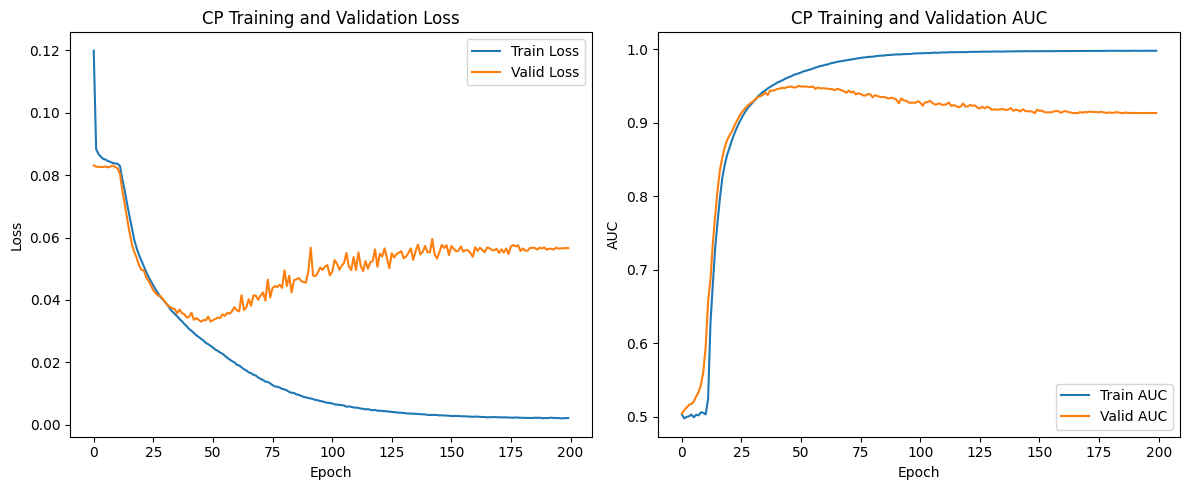

In [10]:
# Plot CP training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CP Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(train_aucs, label='Train AUC')
plt.plot(valid_aucs, label='Valid AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('CP Training and Validation AUC')
plt.tight_layout()
plt.show()

In [22]:

# ------------------------------
# Section 5: Evaluate CP on Test Set
# ------------------------------

# Function to evaluate CP on test set
def evaluate_cp(model, test_dataloader, loss_fn, device):
    """Evaluate the Compatibility Prediction model on the test set.
    
    Args:
        model (OutfitCLIPTransformer): Trained model.
        test_dataloader (DataLoader): Test DataLoader.
        loss_fn (nn.Module): Loss function (FocalLoss).
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        tuple: Test loss and scores (dict with 'auc', 'acc', 'f1', etc.).
    """
    model.eval()
    test_loss, test_preds, test_labels = 0.0, [], []
    pbar = tqdm(test_dataloader, desc='Evaluating CP on Test')
    with torch.no_grad():
        for data in pbar:
            queries = data['query']
            labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
            preds = model(queries, use_precomputed_embedding=True)
            loss = loss_fn(preds, labels)
            test_loss += loss.item()
            test_preds.append(preds)
            test_labels.append(labels)
            pbar.set_postfix(loss=loss.item())
    
    test_loss /= len(test_dataloader)
    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)
    test_scores = compute_cp_scores(test_preds, test_labels)
    
    logger.info(f"CP Test --> Loss: {test_loss:.4f}, AUC: {test_scores['auc']:.4f}, "
               f"Acc: {test_scores['acc']:.4f}, F1: {test_scores['f1']:.4f}")
    print(f"\nCP Test Results:")
    print(f"Pérdida: {test_loss:.4f}")
    print(f"AUC: {test_scores['auc']:.4f}")
    print(f"Accuracy: {test_scores['acc']:.4f}")
    print(f"F1 Score: {test_scores['f1']:.4f}")
    print(f"Precision: {test_scores['precision']:.4f}")
    print(f"Recall: {test_scores['recall']:.4f}")
    
    return test_loss, test_scores

# Load test dataset
test_dataset = PolyvoreCompatibilityDataset(
    dataset_dir=cp_args.polyvore_dir,
    dataset_type=cp_args.polyvore_type,
    dataset_split='test',
    metadata=metadata,
    load_image=False,
    embedding_dict=embedding_dict
)

# Create test DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=cp_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cp_args.n_workers_per_gpu,
    collate_fn=cp_collate_fn
)

# Load model from a specific checkpoint (e.g., epoch_50.pth)
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")
cp_model = load_checkpoint(cp_model, checkpoint_path)
logger.info(f"Loaded CP checkpoint from {checkpoint_path}")

# Evaluate on test set
test_loss, test_scores = evaluate_cp(cp_model, test_dataloader, cp_loss_fn, device)


/tmp/ipykernel_2038804/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

test CP dataset: 20000 outfits, Label distribution: Counter({1: 10000, 0: 10000})


Evaluating CP on Test: 100%|██████████| 625/625 [00:03<00:00, 164.12it/s, loss=0.0178] 



CP Test Results:
Pérdida: 0.0327
AUC: 0.9509
Accuracy: 0.6186
F1 Score: 0.7232
Precision: 0.5676
Recall: 0.9964


In [ ]:

# ------------------------------
# Section 6: Select Best CP Checkpoint
# ------------------------------

# Function to select the best CP checkpoint based on validation AUC
def select_best_cp_checkpoint(checkpoint_dir, valid_dataloader, metadata, device):
    """Select the CP checkpoint with the highest AUC on the validation set.
    
    Args:
        checkpoint_dir (str): Directory containing CP checkpoints.
        valid_dataloader (DataLoader): Validation DataLoader.
        metadata (dict): Item metadata.
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        tuple: Best checkpoint path and its AUC.
    """
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth') and f.startswith('epoch_')]
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
    loss_fn = FocalLoss(alpha=0.5, gamma=2)
    best_auc = 0.0
    best_checkpoint = None
    results = []
    
    for checkpoint_file in checkpoint_files:
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        epoch = int(checkpoint_file.split('_')[1].split('.')[0])
        
        try:
            model = load_checkpoint(model, checkpoint_path)
            logger.info(f"Loaded checkpoint: {checkpoint_path}")
        except Exception as e:
            logger.error(f"Error loading checkpoint {checkpoint_path}: {e}")
            print(f"Error loading checkpoint {checkpoint_path}: {e}")
            continue
        
        model.eval()
        valid_loss, valid_preds, valid_labels = 0.0, [], []
        pbar = tqdm(valid_dataloader, desc=f'Evaluating CP Checkpoint Epoch {epoch}')
        with torch.no_grad():
            for data in pbar:
                queries = data['query']
                labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
                preds = model(queries, use_precomputed_embedding=True)
                loss = loss_fn(preds, labels)
                valid_loss += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
                pbar.set_postfix(loss=loss.item())
        
        valid_loss /= len(valid_dataloader)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)
        valid_scores = compute_cp_scores(valid_preds, valid_labels)
        
        results.append({
            'epoch': epoch,
            'checkpoint': checkpoint_path,
            'valid_loss': valid_loss,
            'auc': valid_scores['auc'],
            'accuracy': valid_scores['acc'],
            'f1': valid_scores['f1'],
            'precision': valid_scores['precision'],
            'recall': valid_scores['recall']
        })
        
        if valid_scores['auc'] > best_auc:
            best_auc = valid_scores['auc']
            best_checkpoint = checkpoint_path
        
        logger.info(f"CP Checkpoint Epoch {epoch} --> Loss: {valid_loss:.4f}, "
                   f"AUC: {valid_scores['auc']:.4f}, Acc: {valid_scores['acc']:.4f}, "
                   f'F1: {valid_scores["f1"]:.4f}')
        print(f"CP Checkpoint Epoch {epoch} --> Loss: {valid_loss:.4f}, "
              f"AUC: {valid_scores['auc']:.4f}, Acc: {valid_scores['acc']:.4f}, "
              f'F1: {valid_scores["f1"]:.4f}')
    
    logger.info(f"Best CP Checkpoint: {best_checkpoint}, AUC: {best_auc:.4f}")
    print(f"\nBest CP Checkpoint: {best_checkpoint}")
    print(f"Best AUC: {best_auc:.4f}")
    
    print("\nAll CP Checkpoint Results:")
    for result in sorted(results, key=lambda x: x['auc'], reverse=True):
        print(f"Epoch {result['epoch']}: AUC={result['auc']:.4f}, "
              f"Accuracy={result['accuracy']:.4f}, F1={result['f1']:.4f}, "
              f"Loss={result['valid_loss']:.4f}, Checkpoint={result['checkpoint']}")
    
    return best_checkpoint, best_auc

# Select best CP checkpoint
best_checkpoint, best_auc = select_best_cp_checkpoint(
    os.path.join(CHECKPOINT_DIR, 'compatibility_clip'),
    valid_dataloader,
    metadata,
    device
)


In [23]:
best_checkpoint = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')